In [202]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

In [535]:
def read_json(json_file):
    """Read the Goldmine json file.
    
    Stitches together broken lines and then
    checks that all lines are correctly formatted.
    
    Parameters
    ----------
    json_file : str
        Filepath to the json file
        
    Returns
    -------
    pandas.core.frame.DataFrame
        A DataFrame with len() == number of rows 
        in the json file
    """
    with open(json_file, 'r') as f_open:
        f_lines = [line.strip() for line in f_open.readlines()]

        # Stitch together broken lines
        f_lines_cleaned = []
        for iLine, line in enumerate(f_lines):
            if len(line) > 0:
                if (line[0]=='{'):
                    f_lines_cleaned.append(line)
                else:
                    f_lines_cleaned[-1] += line

        # Check that all lines are now correctly formatted
        assert np.all([((line[0]=='{') and (line[-1:]=='}')) for line in f_lines_cleaned])

        # Convert json list to a pandas DataFrame
        return pd.read_json('\n'.join([line for line in f_lines_cleaned]), lines=True)

def fill_column(df, key, key_, fill_back=False):
    """Create a column from the values in a df['value'][key_] 
    category for df['key']==key.
    
    if fill_back == True, then values are filled backwards from
    the indices where they occur. Otherwise values are filled
    forward from the indices where they occur.
    
    Returns
    -------
    newcol : list
        The new column values with len() == len(df)
    """
    df_ = df.loc[df['key']==key]
    if len(df_) == 0:
        return None
    
    inds = df_.index.tolist()
    vals = [row[key_] for row in df_['value']]
    
    for i in range(len(inds)+1):
        # Select the value that will be filled
        if i == 0:
            val = vals[i]
        elif fill_back: 
            if i == len(inds):
                val = vals[i - 1]
            else:
                val = vals[i]
        else:
            val = vals[i-1]
        
        # Fill the value over the appropriate
        # number of rows
        if i == 0:
            newcol = [val] * inds[i]
        elif i == len(inds):
            newcol += [val] * (len(df) - inds[i-1])
        else:
            newcol += [val] * (inds[i] - inds[i-1])
    
    return newcol

def get_trial_inds(df):
    """Figure out where each trial begins and ends based on gameState.

    Only complete trials are included.

    Returns
    -------
        trial_inds : itertools.OrderedDict
            (trial, [df_inds]) key/value pairs
    """
    inds = [idx for idx, row in df.query("(key=='gameState')").iterrows() 
            if row['value']['stateName'] in ['InitTrial', 'DoNextTrial']]
    df_ = df.loc[inds]
    trial_inds = od([])
    trial = 1
    iRow = 0
    while iRow < (len(df_)-1):
        if (df_.iloc[iRow]['gameState'] == 'InitTrial') and (df_.iloc[iRow+1]['gameState'] == 'DoNextTrial'):
            trial_inds[trial] = list(np.arange(df_.iloc[iRow].name, df_.iloc[iRow+1].name+1, dtype=int))
            trial += 1
            iRow += 2
        else:
            iRow += 1
    return trial_inds

def game_state_intervals(exp_df, game_state, cols=['time']):
    """Return trial-wise start and stop values for a game state.
    
    Values are determined by the column names in cols and are
    referenced against the index, with a trial period running
    from the first index of the trial to the first index of
    the next trial.
    
    Returns
    -------
    pandas.core.frame.DataFrame
    """
    def first_last(row):
        """Return first and last values in the col iterable."""
        vals = row.index.tolist()
        return [vals[0], vals[-1]+1] 
    
    # Format inputs correctly.
    if type(cols) == str:
        cols = [cols]
    
    # Ensure that all indices are consecutive (i.e. we are not accidentally
    # including another gameState in between values for the desired gameState)
    assert np.all([np.all(np.diff(x)==1) 
                   for x in exp_df.query("(gameState=='{}')".format(game_state))
                   .groupby('trial').indices.values()])

    # Group by trial and get the first and last indices for the gameState.
    output_df = (exp_df.query("(gameState=='{}')".format(game_state))
                       .groupby('trial')
                       .apply(lambda x: first_last(x))
                       .reset_index()
                       .rename(columns={0:'index'}))
    
    # Apply the indices to each column that we want to grab values for.
    for col in cols:
        output_df[col] = output_df['index'].apply(lambda x: [exp_df.loc[x[0], col], 
                                                             exp_df.loc[x[1], col]])
    
    return output_df

def rmse(v1, v2):
    """Return the root mean squared error
    between equal-length vectors v1 and v2.
    """
    err = v1 - v2
    return np.sqrt(np.dot(err, err)/len(err))

def find_pulse_starts(sync_chan, 
                      pulse_thresh=200, # voltage change
                      sampling_rate=32000, # Hz
                      interpulse_thresh_ms=100,
                      intrapulse_thresh_ms=50
                     ): 
    """Return sync_chan indices that mark that start of each sync pulse.
    
    Note: the default arguments were defined on data that were sampled
    at 2000 Hz and might need to be adjusted if the sampling rate
    differs much from this.
    
    Algorithm
    ---------
    1) Identifies sync pulse periods by finding sync channel indices
       for which the absolute value of the trace derivative exceeds
       pulse_thresh. 
    2) Identifies the start of each sync pulse by finding suprathreshold
       sync pulse indices for which the inter-pulse interval exceeds
       interpulse_thresh, and for which the subsequent suprathreshold 
       sync pulse occurs within a certain number of indices, defined by
       intrapulse_thresh. In other words, we are looking for dramatic
       changes in voltage that occur some time after the last dramatic
       voltage change, and that are sustained for some period of time.
    
    Parameters
    ----------
    sync_chan : numpy.ndarray
        Voltage trace from the channel that
        the sync box was plugged into
    pulse_thresh : int or float
        See algorithm description
    sampling_rate : int or float
        Sampling rate of the LFP sync channel in Hz
    interpulse_thresh_ms : int or float
        See algorithm description
    intrapulse_thresh_ms : int or float
        See algorithm description
    
    Returns
    -------
    pulse_startinds : numpy.ndarray
        Array of indices that mark the start of each sync pulse.
    """
    # Find sync pulses by looking for suprathreshold changes 
    # in the absolute value of the derivative of the sync channel
    sync_pulses = np.abs(np.pad(np.diff(sync_chan), (1, 0), 'constant'))>pulse_thresh
    pulse_inds = np.where(sync_pulses)[0]

    # Find the inter-pulse intervals
    ipis = np.insert(np.diff(pulse_inds), 0, pulse_inds[0])

    # Identify the start of each pulse by finding suprathreshold
    # inter-pulse intervals that are followed by a short IPI.
    interpulse_thresh = interpulse_thresh_ms * (sampling_rate / 1000)
    intrapulse_thresh = intrapulse_thresh_ms * (sampling_rate / 1000)
    pulse_startinds = pulse_inds[[i for i in range(len(ipis)-1) 
                                  if ((ipis[i]>interpulse_thresh) 
                                      & (ipis[i+1]<intrapulse_thresh))]]
    return pulse_startinds

def align_sync_pulses(event_synctimes, # vector of event sync times
                      lfp_synctimes, # vector of LFP sync times in ms
                      sampling_rate=32000, # Hz
                      good_fit_thresh_ms=10
                     ):
    """Return the slope and intercept to align event to LFP times.
    
    Algorithm
    ---------
    1) Subtracts the first sync time from all sync times, so
       both vectors start at 0.
    2) Finds the best fit between event and LFP sync times
       by comparing their inter-pulse intervals at 30 offset
       steps for the LFP sync times. An exception is raised if
       a good fit is not found.
    3) Finds the closest LFP sync time to each event sync time.
    4) Estimates the intercept and slope to align event to
       LFP sync times using robust linear regression.
       
    Parameters
    ----------
    event_synctimes : numpy.ndarray
        Vector of event sync times
    lfp_synctimes : numpy.ndarray
        Vector of LFP sync times
    sampling_rate : int or float
        Sampling rate of the LFP sync channel in Hz
    good_fit_thresh_ms : int or float
        Determines the cutoff (in ms) for the mean RMSE between 
        event and LFP inter-pulse times. If we can't find an 
        alignment < this threshold, the function will raise 
        an exception.
        
    Returns
    -------
    sync_params : collections.OrderedDict
        Intercept and slope to align
        event timestamps to LFP timestamps
    before_stats : collections.OrderedDict
        Pearson correlation and RMSE (in ms) between
        event and LFP sync times before alignment.
    after_stats : collections.OrderedDict
        Pearson correlation and RMSE (in ms) between
        event and LFP sync times after alignment.
    """
    def rmse(v1, v2):
        """Return the root mean squared error
        between equal-length vectors v1 and v2.
        """
        err = v1 - v2
        return np.sqrt(np.dot(err, err)/len(err))
        
    def error_percentiles(v1, v2):
        err = np.abs(v1 - v2)
        pcts = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
        return pd.Series([np.percentile(err, pct) for pct in pcts], index=pcts)
    
    # Make the first pulse start at time 0.
    event_synctimes_ = np.copy(event_synctimes - event_synctimes[0])
    lfp_synctimes_ = np.copy(lfp_synctimes - lfp_synctimes[0])
    
    # Find the best starting fit between event and LFP sync times
    # by comparing the inter-pulse intervals for each, testing
    # LFP sync shifts within a 30-index sliding window.
    min_syncs = np.min((len(event_synctimes_), len(lfp_synctimes_)))
    shifts = np.arange(-30, 31, dtype=int)
    ipi_fits = [rmse(np.diff(event_synctimes_),
                     np.roll(np.diff(lfp_synctimes_), shift))
                for shift in shifts]
    best_fit_ind = np.argmin(ipi_fits)
    lfp_synctimes_ = np.roll(lfp_synctimes_, shifts[best_fit_ind])
    print('Best IPI fit ind: {} (shift={}), RMSE={:.2f} ms'
          .format(best_fit_ind, shifts[best_fit_ind], ipi_fits[best_fit_ind]))
    
    # If we couldn't find a good match between the inter-pulse
    # intervals there is no point in trying to align.
    if good_fit_thresh_ms:
        if ipi_fits[best_fit_ind] > good_fit_thresh_ms:
            msg = ('Could not find a good inter-pulse interval alignment (RMSE={:.2f} ms)'
                   .format(ipi_fits[best_fit_ind]))
            raise RuntimeError(msg)
    
    # For each event sync time, find the closest LFP sync time.
    if (len(event_synctimes_) == len(lfp_synctimes_)) & (shifts[best_fit_ind]==0):
        sync_pairs = np.array([(event_synctimes_[i], 
                                lfp_synctimes_[i])
                               for i in range(len(event_synctimes_))])
    else:
        sync_pairs = np.array([(event_synctimes_[i], 
                                lfp_synctimes_[np.abs(lfp_synctimes_ - event_synctimes_[i])
                                               .argmin()])
                               for i in range(len(event_synctimes_))])
    
    # Get a robust linear fit between the event/LFP sync pairs.
    X = sm.add_constant(sync_pairs[:, 0]) # the event sync times
    y = sync_pairs[:, 1] # the LFP channel sync times
    rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    rlm_results = rlm_model.fit()
    intercept, slope = rlm_results.params
    
    # Add back the difference in starting times.
    intercept += (lfp_synctimes[0] - event_synctimes[0])
    
    # See how well the alignment went.
    sync_params = od([('intercept', intercept), ('slope', slope)])
    event_synctimes_aligned = intercept + (slope * event_synctimes)
    before_stats = od([('r', stats.pearsonr(event_synctimes, lfp_synctimes)[0]),
                       ('rmse', rmse(event_synctimes, lfp_synctimes)),
                       ('err_pcts', error_percentiles(event_synctimes, lfp_synctimes))])
    after_stats = od([('r', stats.pearsonr(event_synctimes_aligned, lfp_synctimes)[0]),
                      ('rmse', rmse(event_synctimes_aligned, lfp_synctimes)),
                      ('err_pcts', error_percentiles(event_synctimes_aligned, lfp_synctimes))])
    return sync_params, before_stats, after_stats

def shift_spike_inds(spike_inds, step, floor=0, ceiling=np.inf):
    """Return the time-shifted spike_inds array.
    
    Parameters
    ----------
    spike_inds : numpy.ndarray
        Array of spike time indices.
    floor : int
        The lowest spike index before rolling backward from stop.
    ceiling : int
        One above highest spike index before rolling forward from start.
    step : int
        Number of indices to shift the spike train by.
    """
    ceiling -= floor
    spike_inds_shifted = (spike_inds-floor) + step
    
    if step < 0:
        roll_by = -len(spike_inds_shifted[spike_inds_shifted<0])
        spike_inds_shifted[spike_inds_shifted<0] = spike_inds_shifted[spike_inds_shifted<0] + ceiling
    else:
        roll_by = len(spike_inds_shifted[spike_inds_shifted>=ceiling])
        spike_inds_shifted[spike_inds_shifted>=ceiling] = spike_inds_shifted[spike_inds_shifted>=ceiling] - ceiling

    spike_inds_shifted = np.roll(spike_inds_shifted, roll_by) + floor

    return spike_inds_shifted

def cos_sim(x, y):
    """Return the cosine similarity between x and y."""
    x = np.array(x)
    y = np.array(y)
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def info_rate(fr_given_x, prob_x=None):
    """Return the information rate of a cell in bits/spike.
    
    From Skaggs et al., 1993.
    
    Parameters
    ----------
    fr_given_x : numpy.ndarray
        A vector of firing rates for each state x in the 
        range len(fr_given_x).
    prob_x : numpy.ndarray
        A vector of probability densities for each state 
        x in the range len(fr_given_x). If prob_x is
        None then uniform probabilities are assumed.
    """
    if prob_x is None:
        n_states = len(fr_given_x)
        mean_fr = np.sum(fr_given_x) / n_states
        bits_per_sec = np.sum(fr_given_x * np.log2(fr_given_x/mean_fr)) / n_states
    else:
        mean_fr = np.dot(prob_x, fr_given_x)
        bits_per_sec = np.sum(fr_given_x * np.log2(fr_given_x/mean_fr) * prob_x)
    bits_per_spike = bits_per_sec / mean_fr
    return bits_per_spike

In [12]:
subj_sess = 'U518_ses0'
data_dir = '/scratch/dscho/time_cells/data'
analysis_dir = '/scratch/dscho/time_cells/analysis'
sampling_rate = 30000

# --------------------------------------
## Get subject directories.
subj, sess = subj_sess.split('_')
subj_dir = os.path.join(data_dir, subj, sess)
events_dir = os.path.join(subj_dir, 'events')
spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_sortbyhand')
micros_dir = os.path.join(subj_dir, 'micro_lfps')
sync_dir = os.path.join(subj_dir, 'sync')
sr = sampling_rate

# --------------------------------------
## Load events.
events_f = os.path.join(analysis_dir, 'events', '{}_events_formatted.pkl'.format(subj_sess))
events = dio.open_pickle(events_f)
print('Events shape: {}'.format(events.shape))
print('{} min, {} sec\n'.format(int((events.iloc[-1]['time'] - events.iloc[0]['time'])/6e4), 
                                int(((events.iloc[-1]['time'] - events.iloc[0]['time'])%6e4)/1e3)))

# --------------------------------------
## Load spikes.
spikes_f = os.path.join(analysis_dir, 'spikes', '{}_spikes.pkl'.format(subj_sess))
spikes = dio.open_pickle(spikes_f)
def percentiles(x):
    qs = []
    for q in [0, 10, 25, 50, 75, 90, 100]:
        qs.append(np.round(np.percentile(x, q), 2))
    return qs
print('Spikes shape: {}'.format(spikes.shape))
display(spikes.groupby('hemroi').agg({'unit': len, 'chan': lambda x: len(np.unique(x)), 'fr': lambda x: percentiles(x)}))

Events shape: (72204, 8)
67 min, 7 sec

Spikes shape: (56, 9)


,unit,chan,fr
hemroi,,,
LA,6,6,"[0.72, 0.81, 0.93, 1.4, 1.93, 2.52, 3.05]"
LAI,8,7,"[0.22, 0.26, 0.3, 0.36, 1.0, 2.25, 4.59]"
LMH,11,7,"[0.51, 0.83, 0.94, 2.85, 5.72, 8.0, 8.54]"
LO,6,5,"[1.36, 1.79, 2.49, 4.22, 6.34, 13.89, 21.04]"
LTO,3,3,"[1.61, 1.71, 1.86, 2.11, 11.6, 17.3, 21.1]"
LTPO,5,3,"[1.0, 1.02, 1.05, 2.6, 4.34, 4.79, 5.08]"
REC,6,6,"[0.58, 0.72, 0.88, 1.04, 1.15, 4.94, 8.73]"
RIP,2,2,"[0.13, 0.15, 0.17, 0.21, 0.24, 0.27, 0.28]"
RTO,9,7,"[0.77, 1.24, 2.25, 6.43, 10.33, 13.56, 13.67]"


In [22]:
# Get the start and stop times for each task period, for each trial.
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

dfs = []
for iState, game_state in enumerate(game_states):
    dfs.append(game_state_intervals(events, game_state=game_state, cols=['time']))
    dfs[-1].insert(1, 'trial_phase', iState+1)
    dfs[-1].insert(2, 'gameState', game_state)
    
event_times = pd.concat(dfs, axis=0)

# Divide each task period into 60 time bins of equal duration
# (should be ~500 ms each)
time_bins = []
for idx, row in event_times.iterrows():
    if row['gameState'] in ['Encoding', 'Retrieval']:
        n_time_bins = 60
    elif row['gameState'] in ['Delay1', 'Delay2']:
        n_time_bins = 20
    time_bins.append(np.linspace(row['time'][0], row['time'][1], num=n_time_bins+1))
event_times['time_bins'] = time_bins
event_times = event_times.sort_values(['trial', 'trial_phase']).reset_index(drop=True)
time_bins = event_times['time_bins'].tolist()

print(event_times.shape, len(time_bins))

(144, 6) 144


In [58]:
## For each neuron, get the number of spikes in each time bin.
start_time = time()

spikes_by_time = []
for time_bins in event_times['time_bins']:
    spikes_by_time.append(np.array([[np.sum(np.logical_and(spikes.loc[iUnit, 'spike_times']>time_bins[iTime], 
                                                  spikes.loc[iUnit, 'spike_times']<=time_bins[iTime+1]))
                                     for iTime in range(len(time_bins)-1)]
                                    for iUnit in range(len(spikes))]))

# Combine time bins across trial phases in each trial.
trial_spikes_by_time = []
for iTrial in np.arange(0, len(spikes_by_time), step=len(game_states)):
    arr = [spikes_by_time[i] for i in np.arange(iTrial, iTrial+len(game_states))]
    trial_spikes_by_time.append(np.concatenate(arr, axis=1))
trial_spikes_by_time = np.swapaxes(trial_spikes_by_time, 0, 1) # neuron x trial x time_bin
    
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 24.85 secs


In [88]:
# Z-score spike counts across time and trial to normalize
# contributions from each neuron.
shp = trial_spikes_by_time.shape
trial_spikes_by_time_z = stats.zscore(np.reshape(trial_spikes_by_time, (shp[0], shp[1]*shp[2])), axis=1).reshape(shp)

In [138]:
rois = od()
for roi, df in spikes.groupby('hemroi', sort=False):
    rois[roi] = [len(df), df.index.tolist()[0]]
rois

OrderedDict([('REC', [6, 0]),
             ('RTO', [9, 6]),
             ('RIP', [2, 15]),
             ('LA', [6, 17]),
             ('LMH', [11, 23]),
             ('LTO', [3, 34]),
             ('LAI', [8, 37]),
             ('LO', [6, 45]),
             ('LTPO', [5, 51])])

In [199]:
trial_spikes_by_time_z.shape

(56, 36, 160)

In [219]:
stats.linregress(np.mean(trial_spikes_by_time_z, axis=1).flatten(), np.tile(np.arange(trial_spikes_by_time_z.shape[2]), trial_spikes_by_time_z.shape[0]))

LinregressResult(slope=-1.0917854178247404, intercept=79.5, rvalue=-0.005596972766101269, pvalue=0.5963030060014147, stderr=2.0609704464778478)

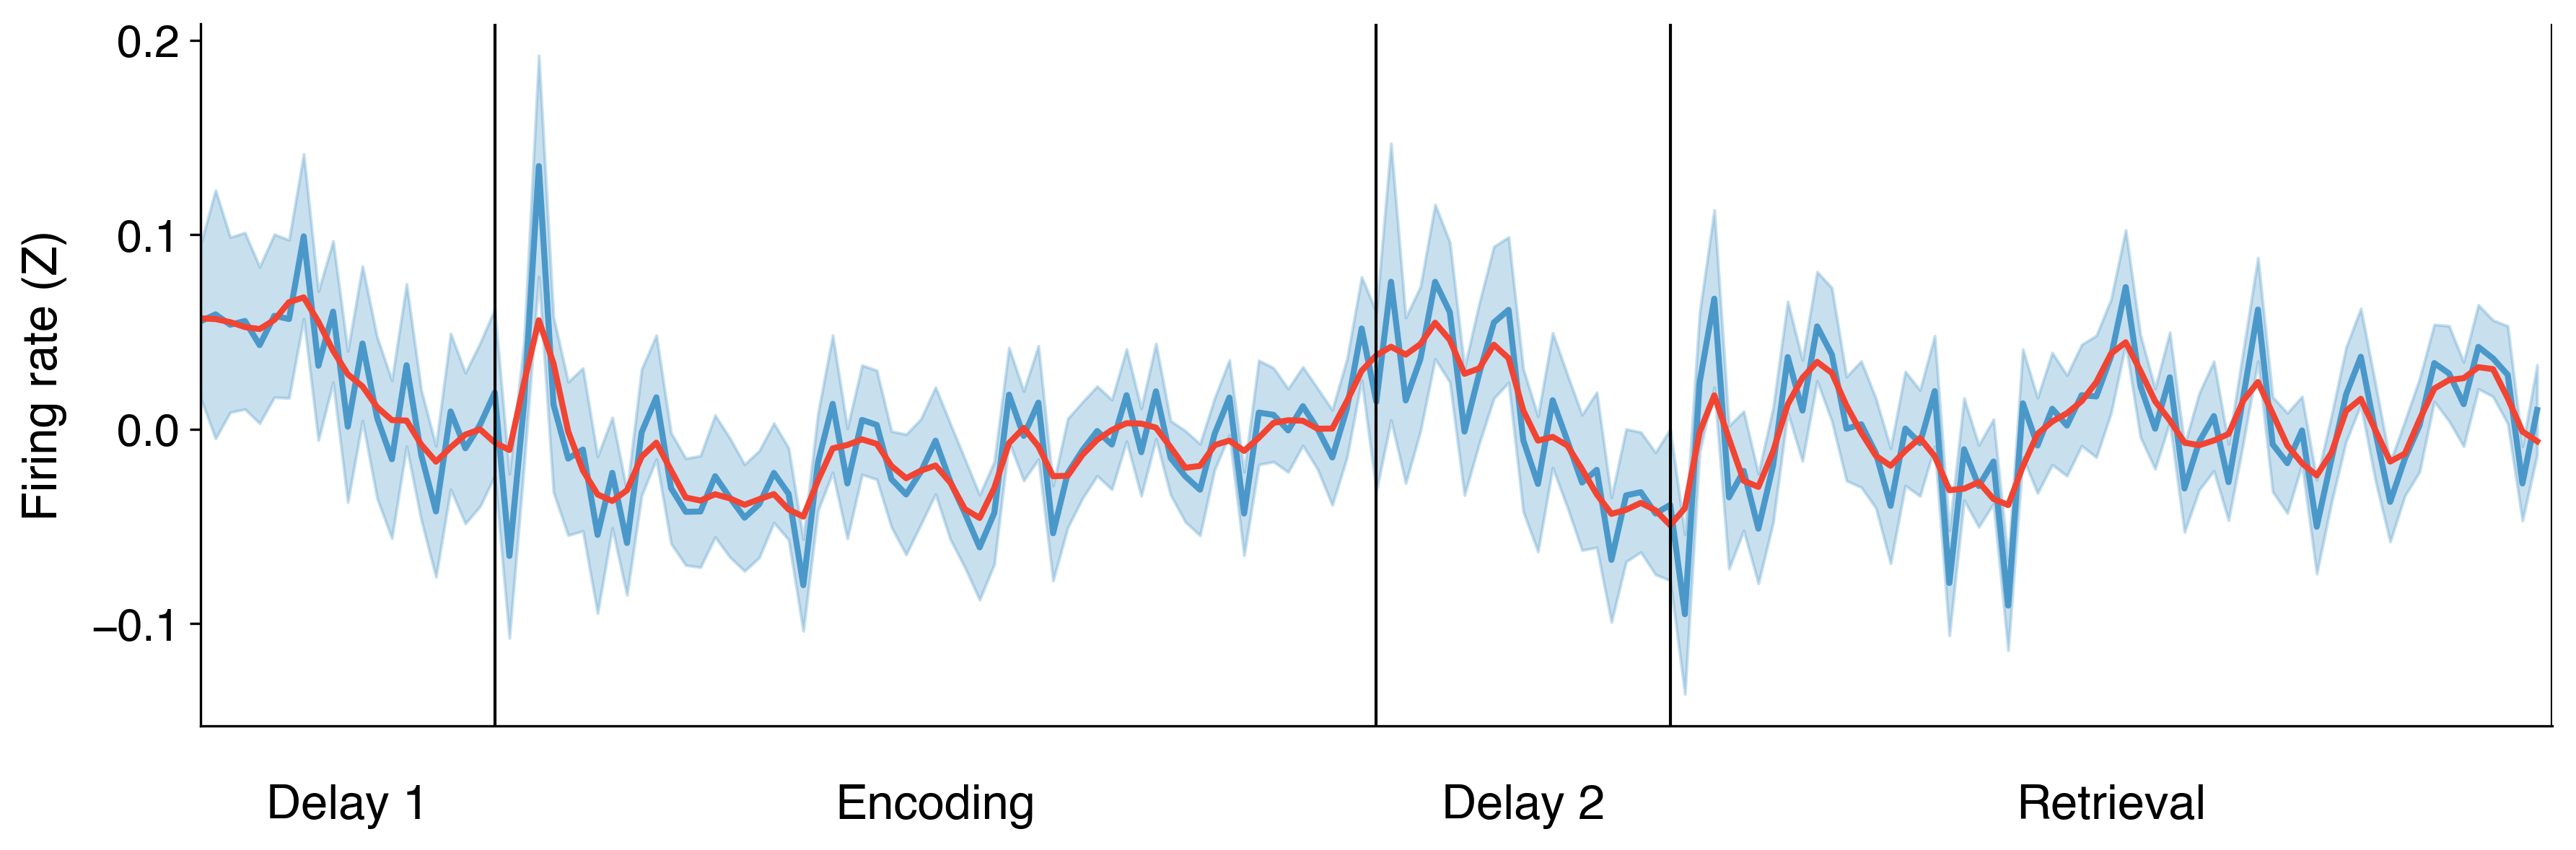

In [550]:
means = np.mean(trial_spikes_by_time_z, axis=(0, 1))
sems = stats.sem(np.mean(trial_spikes_by_time_z, axis=1), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)
labelfontsize = 16
tickfontsize = 16

ax.plot(means, color=colors[0], linewidth=2)
ax.plot(gaussian_filter(means, sigma=1, mode='mirror'), linewidth=2, color=colors[1])
ax.fill_between(np.arange(len(means)), means + sems, means - sems, color=colors[0], alpha=0.3)
trial_phase_divides = [20, 80, 100, 160]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='k', linewidth=1, alpha=1)
ax.set_xlim([0, len(means)])
ax.set_xticks([])
ax.set_ylabel('Firing rate (Z)', fontsize=labelfontsize, labelpad=8)

ax.annotate('Delay 1', (10, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Encoding', (50, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Delay 2', (90, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Retrieval', (130, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)

fig.tight_layout()

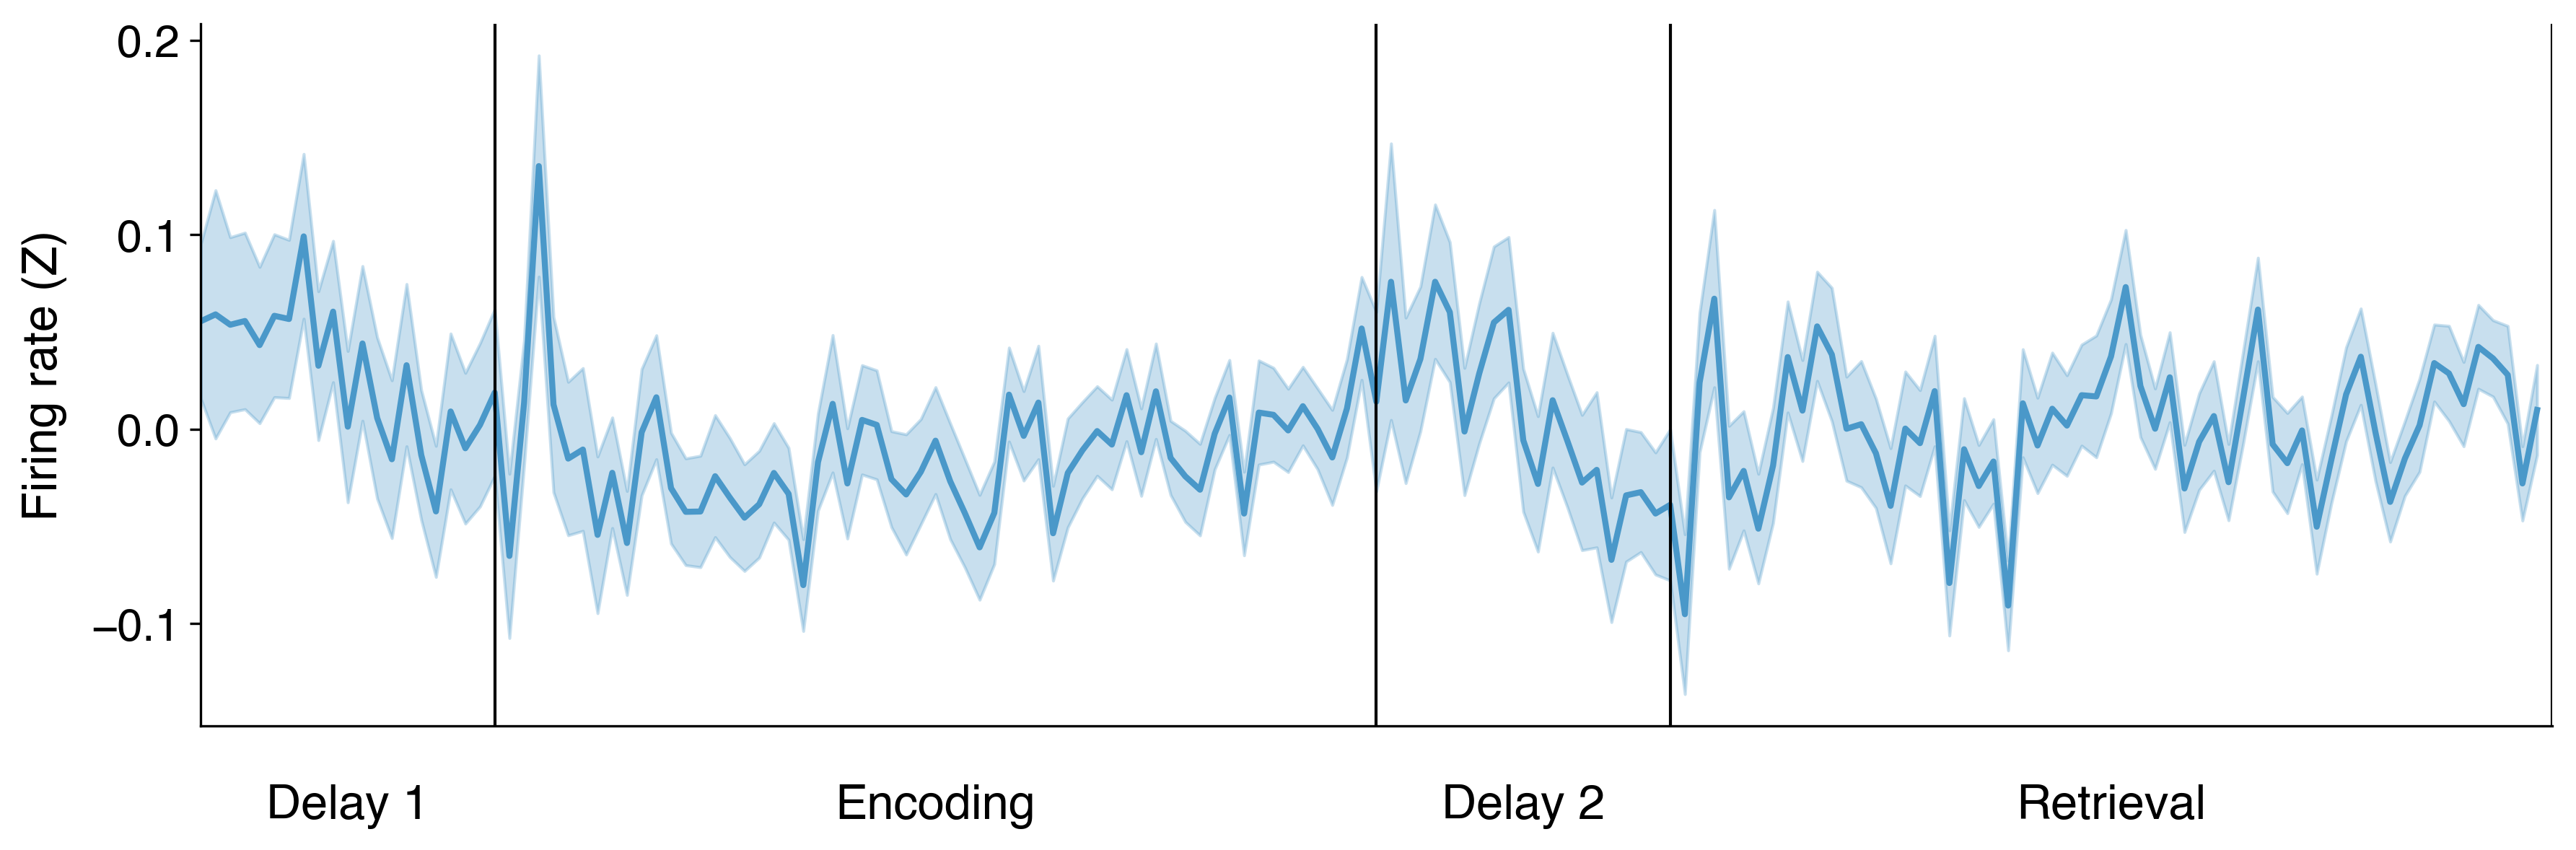

In [223]:
means = np.mean(trial_spikes_by_time_z, axis=(0, 1))
sems = stats.sem(np.mean(trial_spikes_by_time_z, axis=1), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)
labelfontsize = 16
tickfontsize = 16

ax.plot(means, color=colors[0], linewidth=2)
ax.fill_between(np.arange(len(means)), means + sems, means - sems, color=colors[0], alpha=0.3)
trial_phase_divides = [20, 80, 100, 160]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='k', linewidth=1, alpha=1)
ax.set_xlim([0, len(means)])
ax.set_xticks([])
ax.set_ylabel('Firing rate (Z)', fontsize=labelfontsize, labelpad=8)

ax.annotate('Delay 1', (10, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Encoding', (50, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Delay 2', (90, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Retrieval', (130, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)

fig.tight_layout()

In [225]:
np.array(list(rois.values()))[:, 1], np.array(list(rois.values()))[:, 1][:-1] + np.diff(np.array(list(rois.values()))[:, 1])/2



(array([ 0,  6, 15, 17, 23, 34, 37, 45, 51]),
 array([ 3. , 10.5, 16. , 20. , 28.5, 35.5, 41. , 48. ]))

In [242]:
rois.keys(), list(np.array(list(rois.values()))[:, 1][:-1] + np.diff(np.array(list(rois.values()))[:, 1])/2)

(odict_keys(['REC', 'RTO', 'RIP', 'LA', 'LMH', 'LTO', 'LAI', 'LO', 'LTPO']),
 [3.0, 10.5, 16.0, 20.0, 28.5, 35.5, 41.0, 48.0])

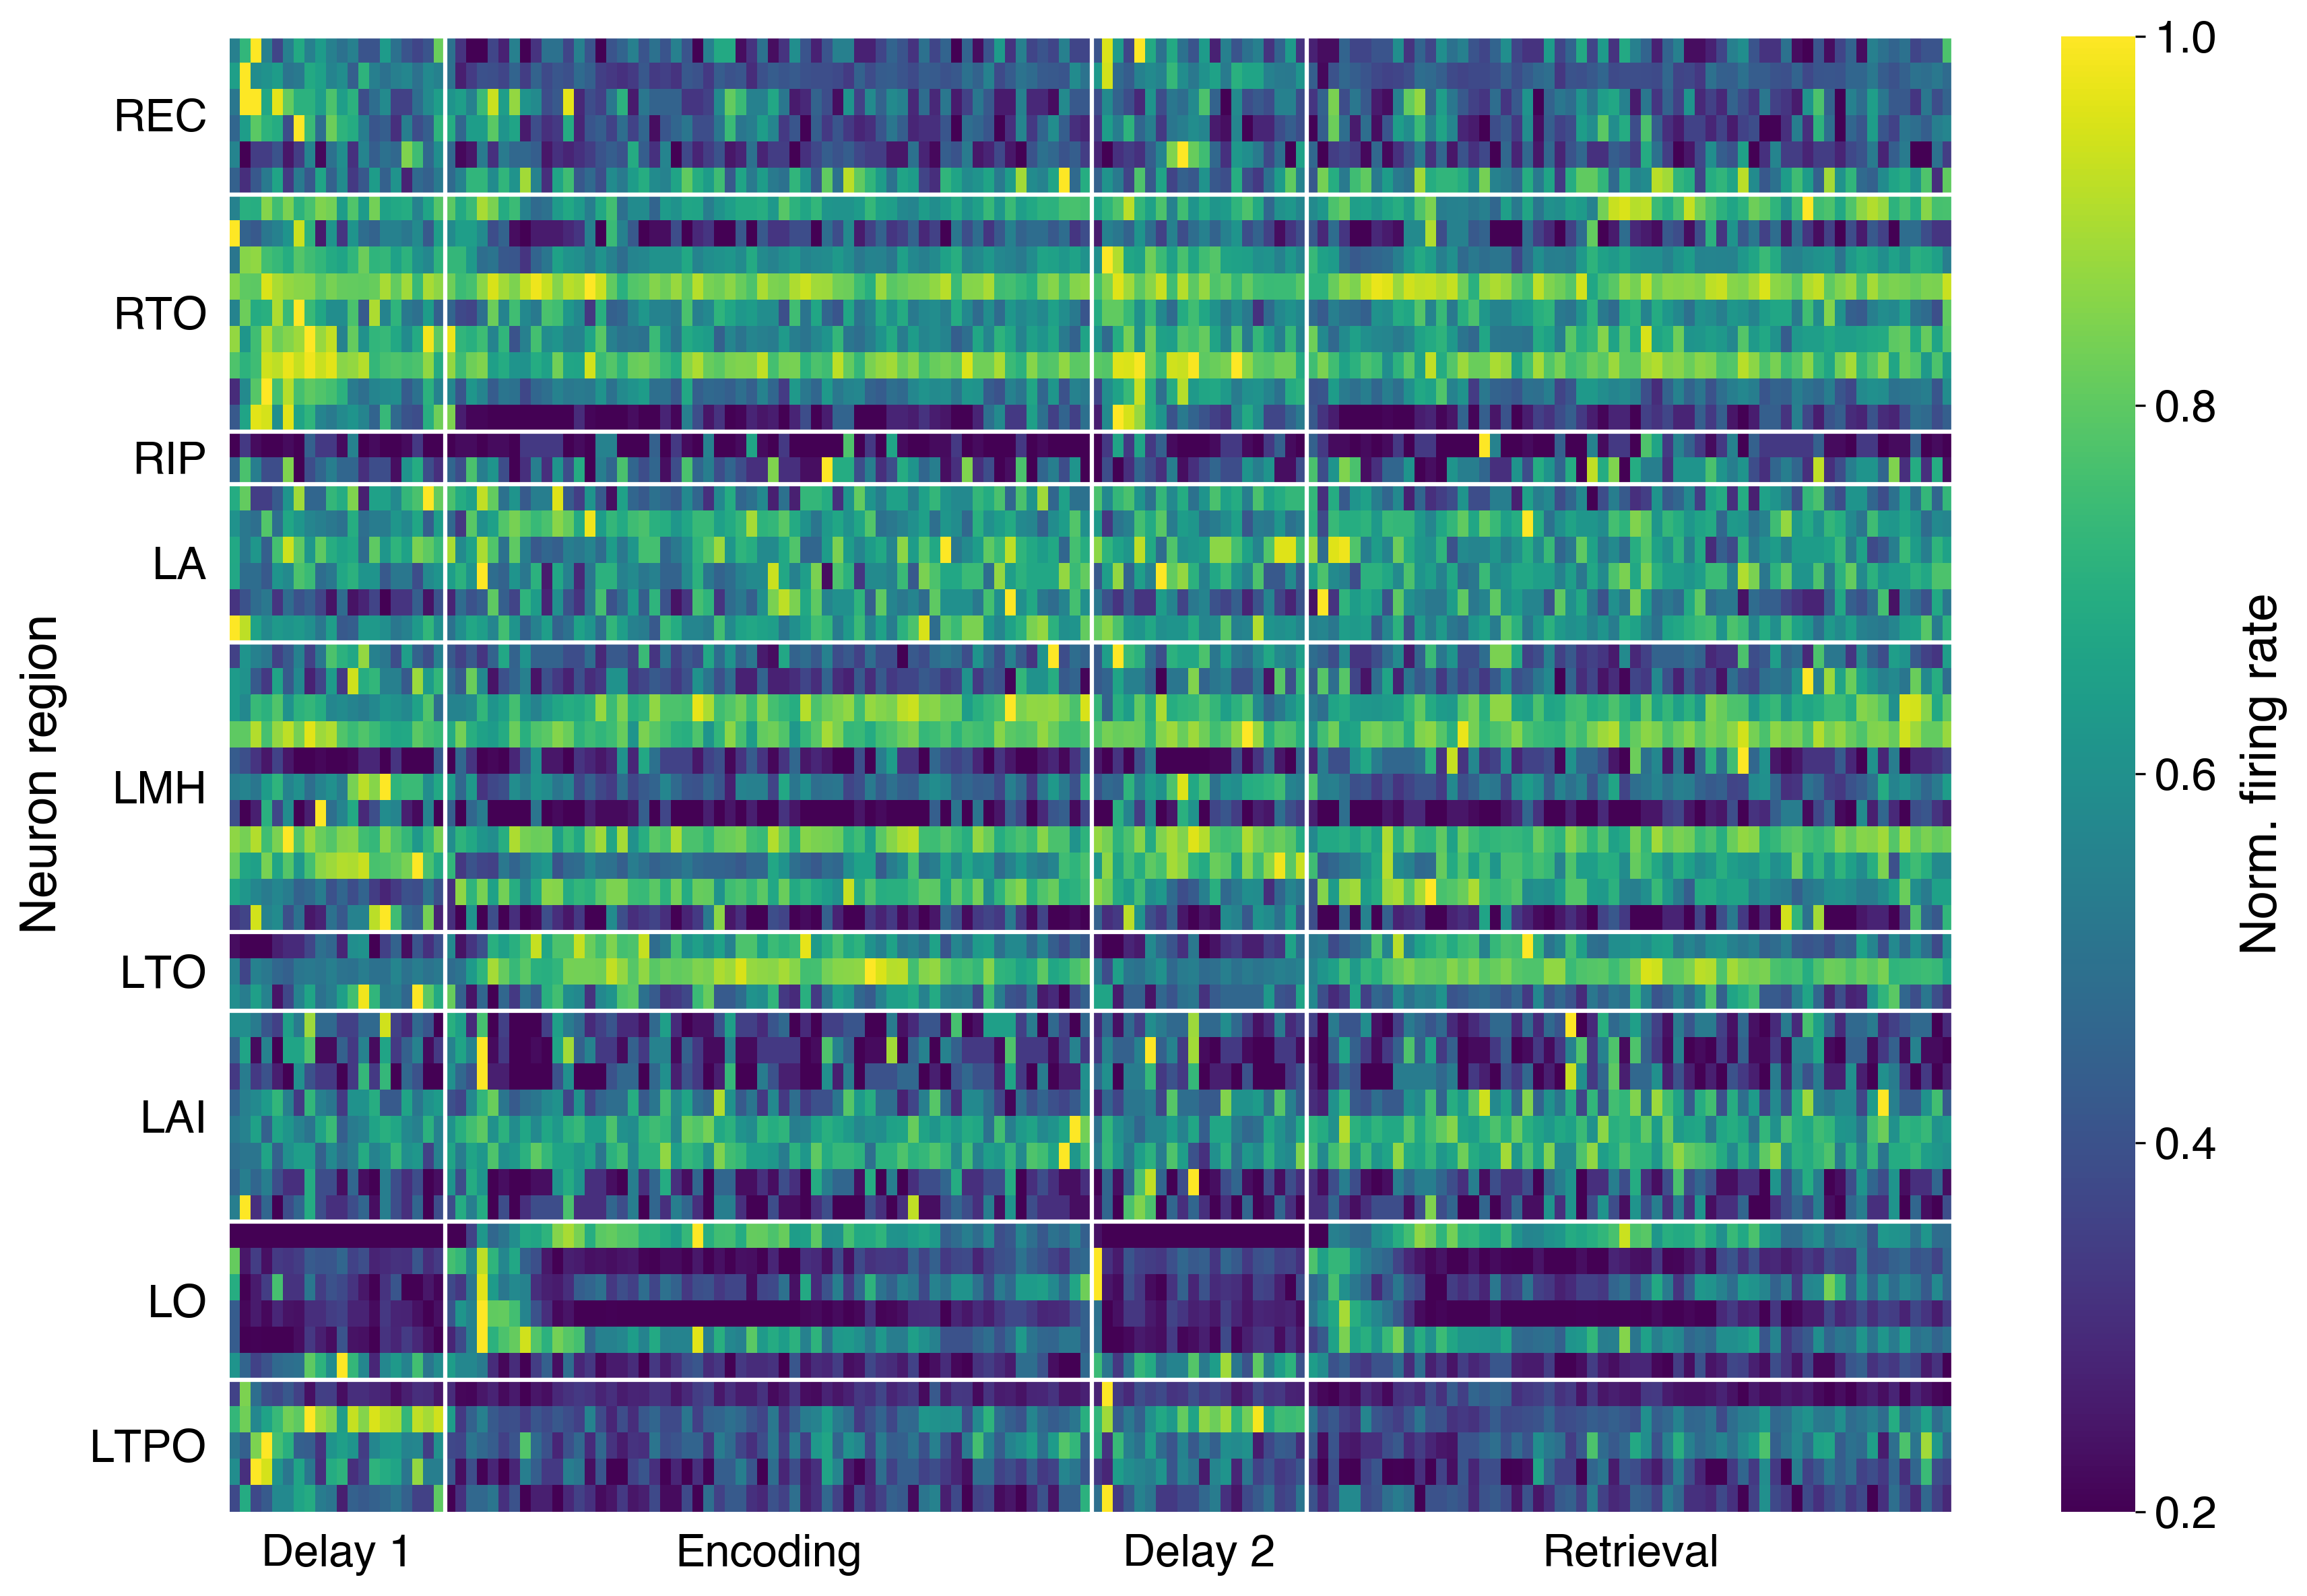

In [250]:
dat = np.sum(trial_spikes_by_time, axis=1) # neuron x time
dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#dat = dat[np.argsort(dat.argmax(axis=-1)), :]

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
tickfontsize = 16
labelfontsize = 18

vmin = 0.2
vmax = 1
xticks = [10, 50, 90, 130]
yticks = (list(np.array(list(rois.values()))[:, 1][:-1] + np.diff(np.array(list(rois.values()))[:, 1])/2) 
          + [np.array(list(rois.values()))[-1, 1] + (np.array(list(rois.values()))[-1, 0]/2)])

ax = sns.heatmap(dat, ax=ax,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = [20, 80, 100, 160]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='w', linewidth=1.5, alpha=1)
for iRoi in range(len(rois)):
    ax.axhline(y=np.array(list(rois.values()))[:, 1][iRoi], color='w', linewidth=1.5, alpha=1)
ax.tick_params(axis='both', which='both', length=0, pad=8)
ax.set_xticks(xticks)
ax.set_xticklabels(['Delay 1', 'Encoding', 'Delay 2', 'Retrieval'], fontsize=tickfontsize, rotation=0)
ax.set_yticks(yticks)
ax.set_yticklabels(list(rois.keys()), fontsize=tickfontsize)
ax.set_ylabel('Neuron region', fontsize=labelfontsize, labelpad=8)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_ticklabels(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()

In [283]:
sig_cells_delay = np.array([1, 6, 8, 12, 13, 14, 22, 25, 32, 35, 45, 46, 47, 48, 49, 50, 51, 52, 53])

In [280]:
mpoint = int(trial_spikes_by_time.shape[1]/2)

m = np.array([np.argmax(np.mean(trial_spikes_by_time[:, :, :20], axis=1), axis=1),
              np.argmax(np.mean(trial_spikes_by_time[:, :, 80:100], axis=1), axis=1)])
print('Delay 1 vs. Delay 2 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

m = np.array([np.argmax(np.mean(np.concatenate((trial_spikes_by_time[:, :mpoint, :20], 
                                                trial_spikes_by_time[:, :mpoint, 80:100]), axis=1), axis=1), axis=1),
              np.argmax(np.mean(np.concatenate((trial_spikes_by_time[:, mpoint:, :20], 
                                                trial_spikes_by_time[:, mpoint:, 80:100]), axis=1), axis=1), axis=1)])
print('Trials 1-18 vs. Trials 19-36 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

Delay 1 vs. Delay 2 max FR times: (0.19046880135924443, 0.15969442908335776)
Trials 1-18 vs. Trials 19-36 max FR times: (0.29692099361327184, 0.026268665746843656)


In [284]:
mpoint = int(trial_spikes_by_time.shape[1]/2)

m = np.array([np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, :20], axis=1), axis=1),
              np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, 80:100], axis=1), axis=1)])
print('Delay 1 vs. Delay 2 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

m = np.array([np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, :20], 
                                                trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100]), axis=1), axis=1), axis=1),
              np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, mpoint:, :20], 
                                                trial_spikes_by_time[sig_cells_delay, mpoint:, 80:100]), axis=1), axis=1), axis=1)])
print('Trials 1-18 vs. Trials 19-36 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

Delay 1 vs. Delay 2 max FR times: (0.39348839090995397, 0.09556163017343497)
Trials 1-18 vs. Trials 19-36 max FR times: (0.5932811983045507, 0.007415725280047222)


min=0.22


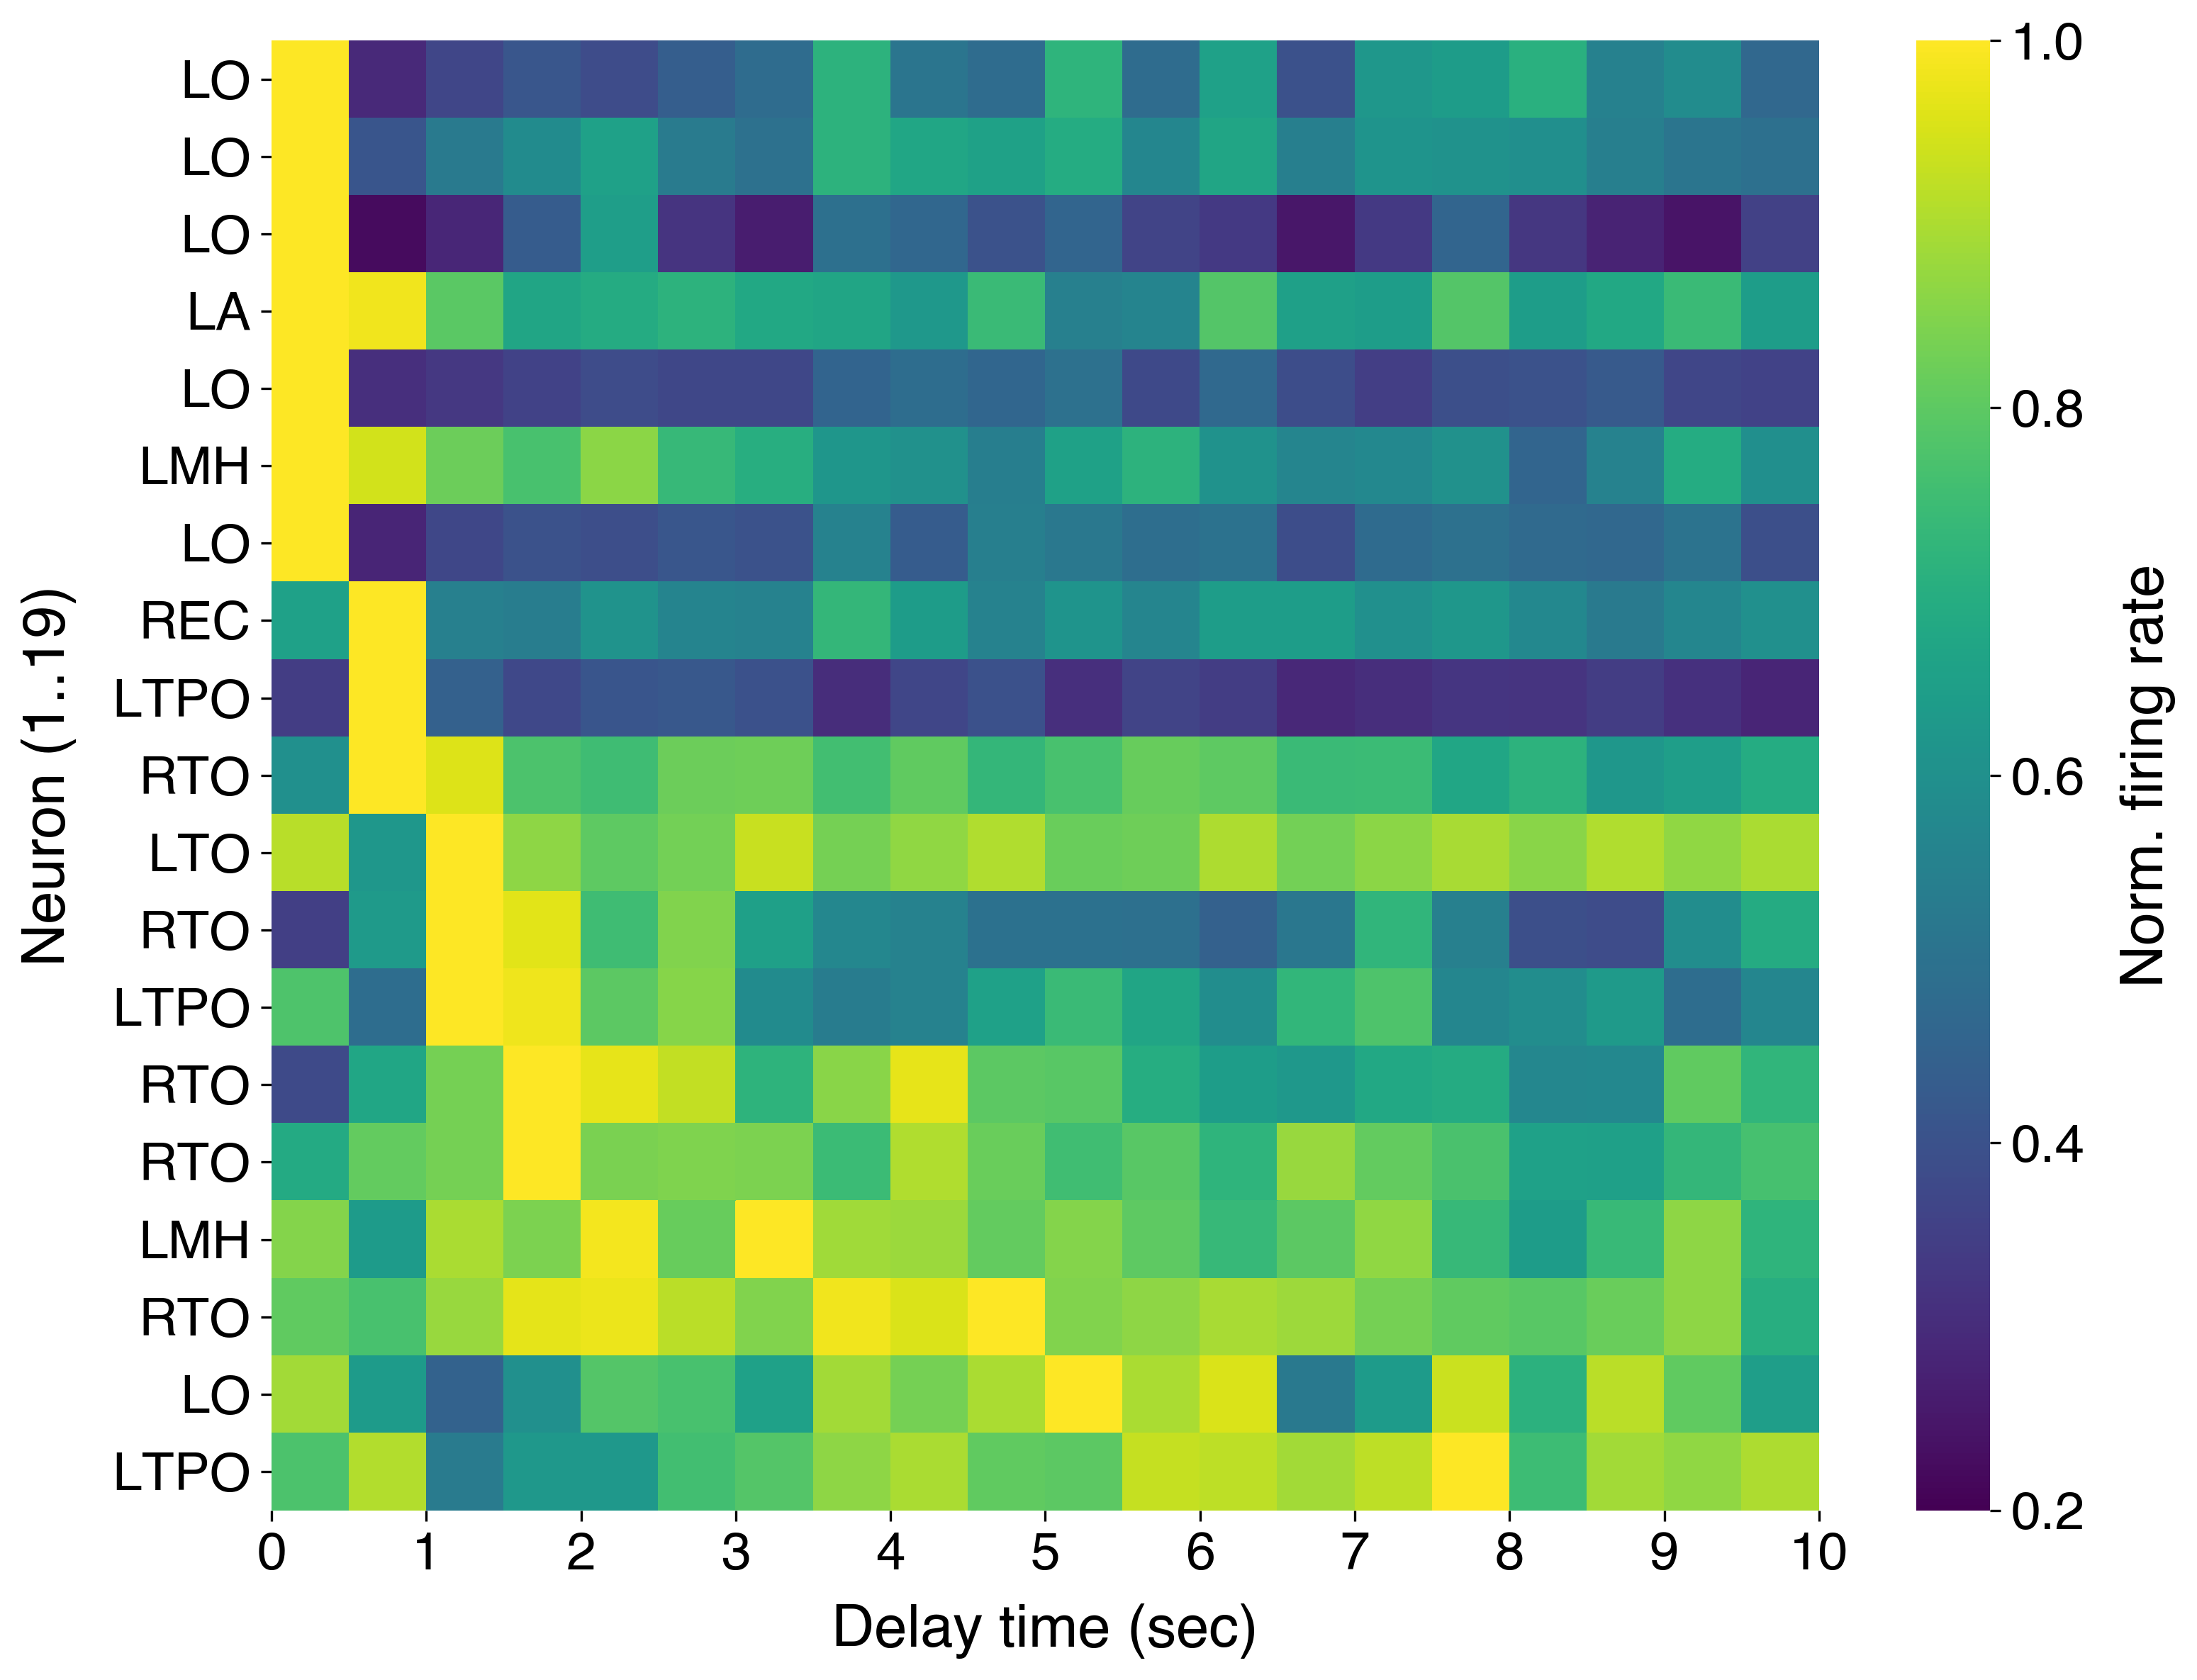

In [295]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
xtrial_delay_spikes = np.sum(np.concatenate((trial_spikes_by_time[sig_cells_delay, :, :20], 
                                             trial_spikes_by_time[sig_cells_delay, :, 80:100]), axis=1), 
                             axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10.5, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 18
labelfontsize = 20

vmin = 0.2
vmax = 1

i = 0
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=True, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=12)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=12)

fig.tight_layout()

min=0.22


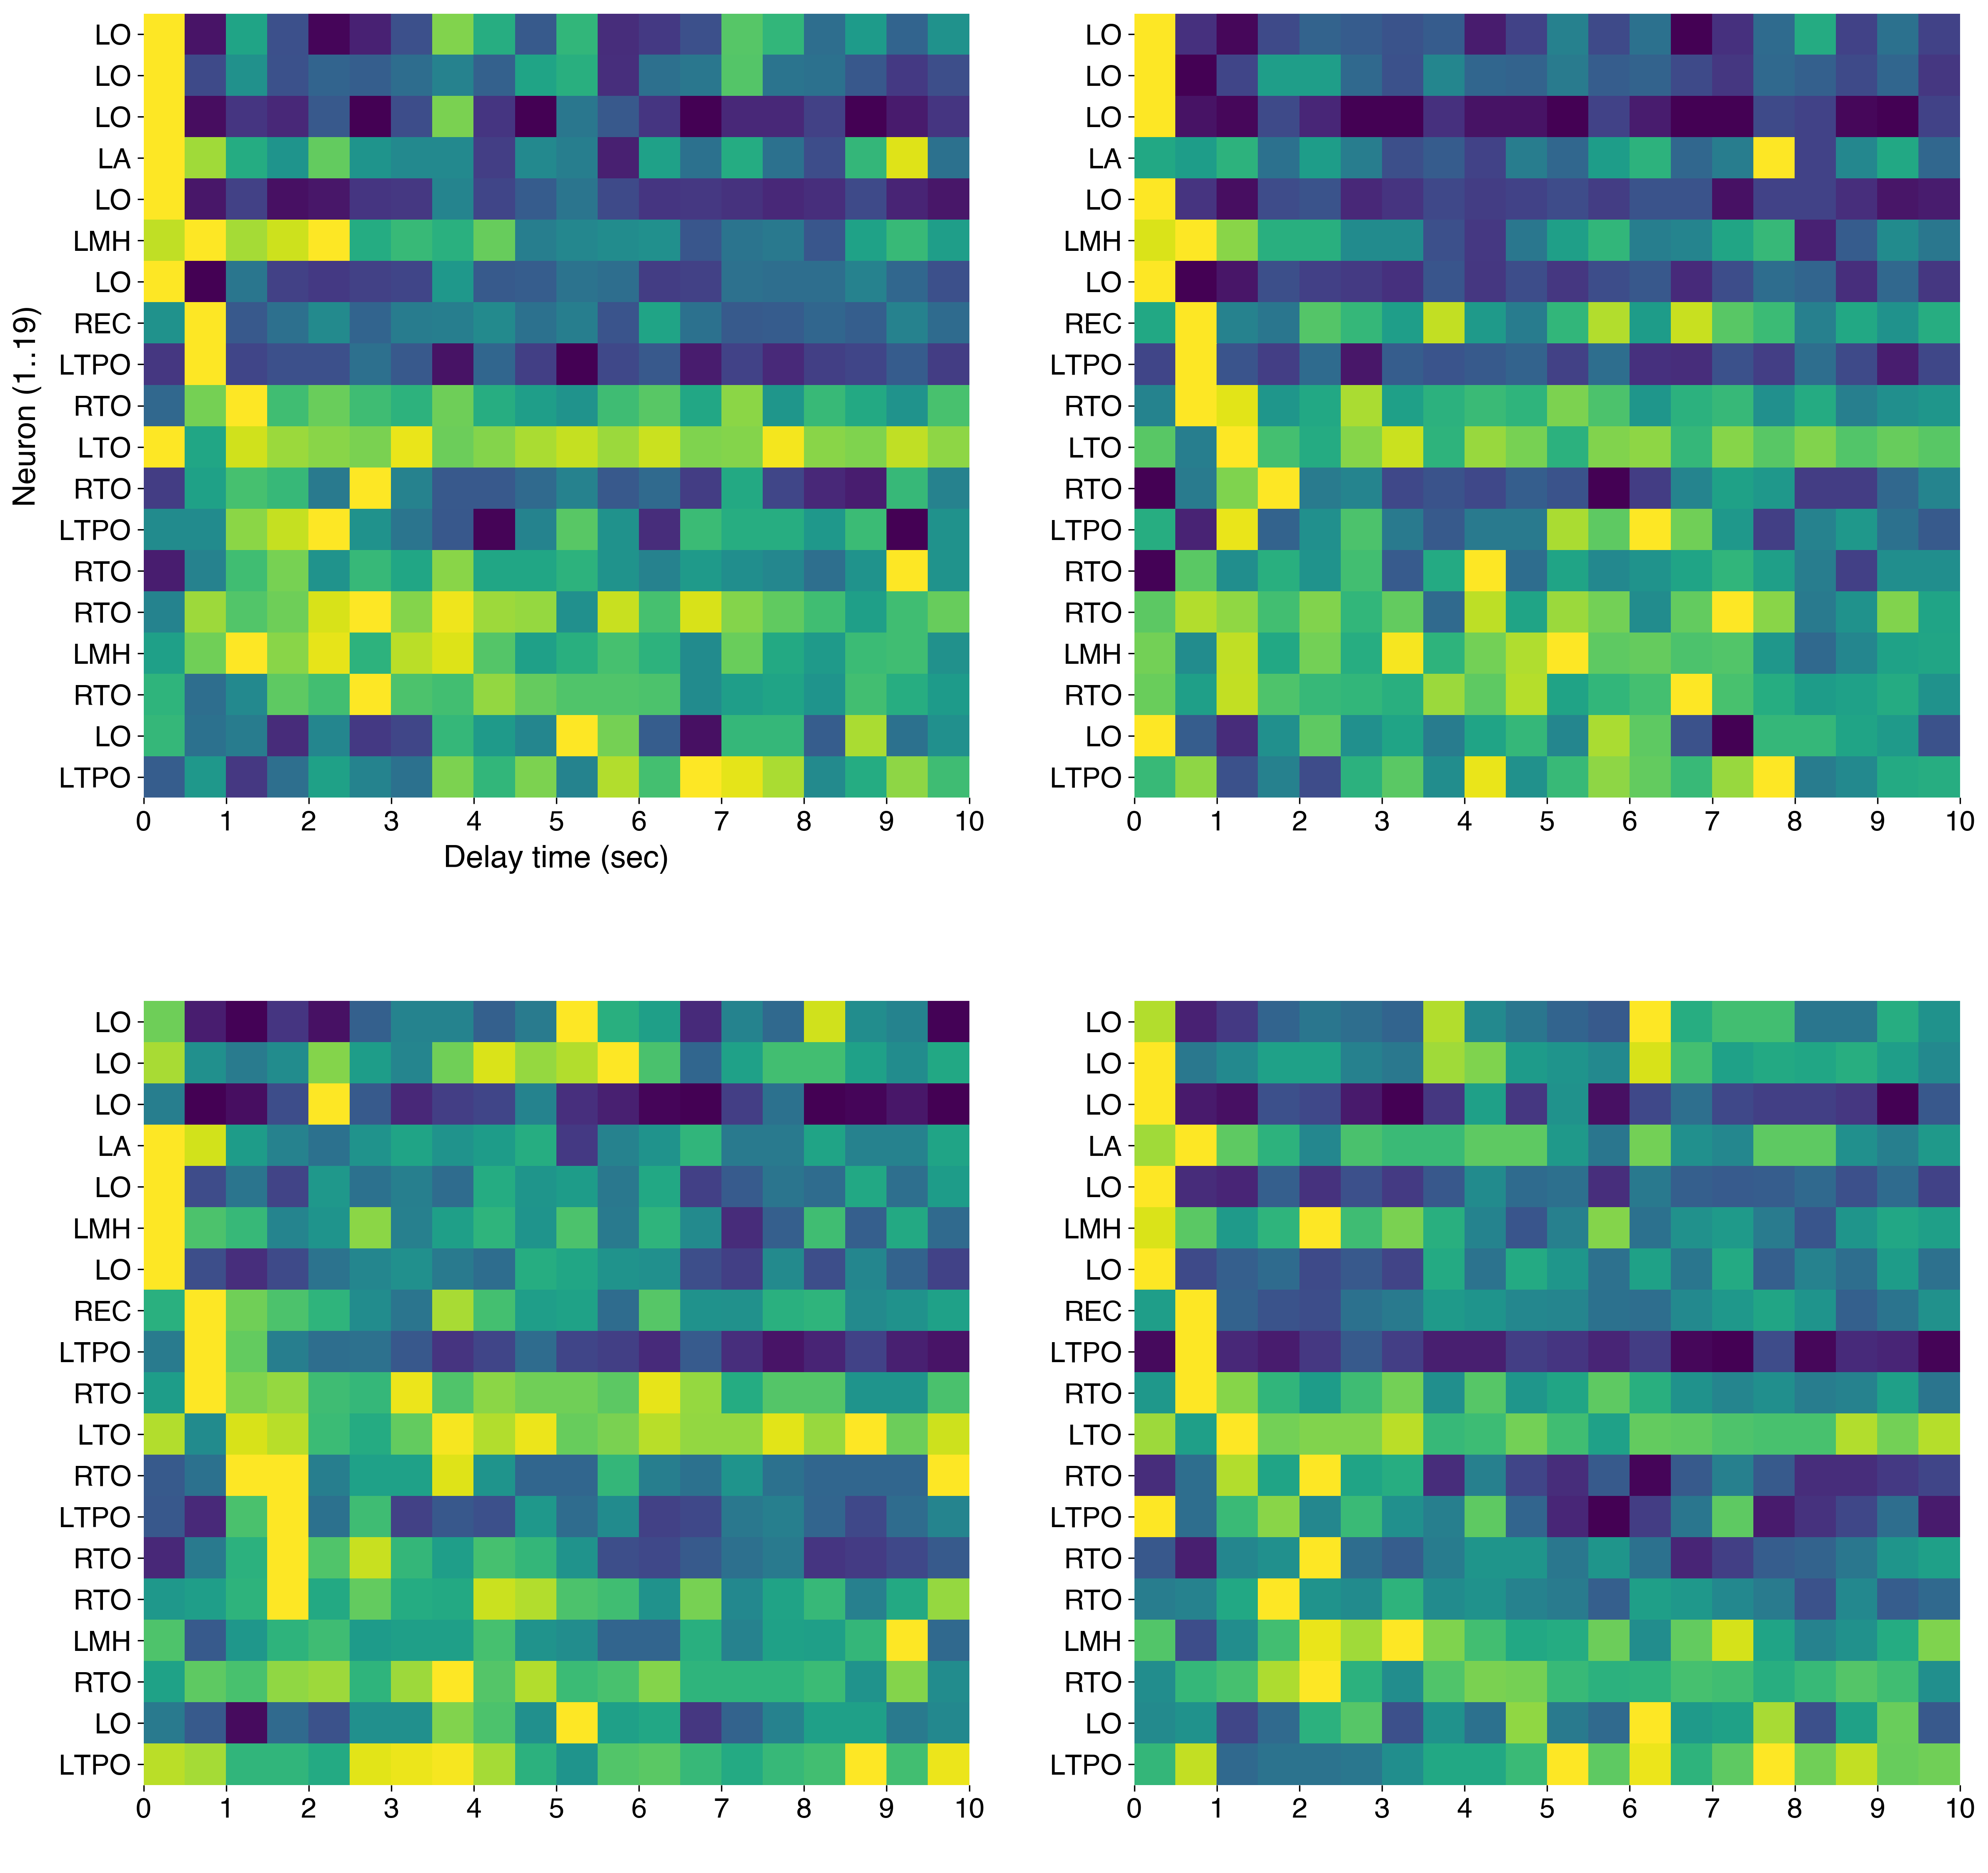

In [291]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
xtrial_delay_spikes = np.sum(np.concatenate((trial_spikes_by_time[sig_cells_delay, :, :20], 
                                             trial_spikes_by_time[sig_cells_delay, :, 80:100]), axis=1), 
                             axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(2, 2, figsize=(16, 16), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

vmin = 0.2
vmax = 1

i = 0
dat = np.sum(trial_spikes_by_time[show_units_delay, :mpoint, :20], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

i = 1
dat = np.sum(trial_spikes_by_time[show_units_delay, :mpoint, 80:100], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel(' '.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

i = 2
dat = np.sum(trial_spikes_by_time[show_units_delay, mpoint:, :20], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel(' '.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

i = 3
dat = np.sum(trial_spikes_by_time[show_units_delay, mpoint:, 80:100], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel(' '.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

fig.tight_layout()

In [334]:
trial_spikes_by_time.shape

(56, 36, 160)

In [335]:
np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, :20], trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100]), axis=1), axis=1).shape

(19, 20)

In [332]:
np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, :20], trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100]), axis=1), axis=1).shape

(19, 20)

In [364]:
trial_spikes_by_time[sig_cells_delay, :mpoint, :20].shape, np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, :20], axis=1).shape

((19, 18, 20), (19, 20))

In [383]:
split_frs[cond][0][0].shape, len(sig_cells_delay)

((19, 20), 19)

In [494]:
# Calculate the Pearson correlation between firing rate vectors from the
# first and second half of the testing session, comparing Delay 1 to Delay 1,
# Delay 2 to Delay 2, Delay 1 to Delay 2, and Delay 2 to Delay 1.

# Trial 1-18 vs. 19-36 firing rate vectors (Delay 1 vs. Delay 1 and Delay 2 vs. Delay 2)
mpoint = int(trial_spikes_by_time.shape[1]/2)
split_frs = od([('match', [[np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, :20], axis=1), # each row is neuron x time (mean over delays)
                            np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, :20], axis=1)],
                           [np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100], axis=1),
                            np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, 80:100], axis=1)]]),
                ('mismatch', [[np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, :20], axis=1),
                               np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, 80:100], axis=1)],
                              [np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100], axis=1),
                               np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, :20], axis=1)]])])

# Get the cosine similarity between each pair of firing vectors.
fr_corrs = od()
fr_pvals = od()
for cond in ['match', 'mismatch']:
    fr_corrs[cond] = []
    fr_pvals[cond] = []
    for ii in range(2):
        fr_corrs[cond].append([stats.pearsonr(split_frs[cond][ii][0][iUnit, :], split_frs[cond][ii][1][iUnit, :])[0]
                               for iUnit in range(len(sig_cells_delay))])
        fr_pvals[cond].append([stats.pearsonr(split_frs[cond][ii][0][iUnit, :], split_frs[cond][ii][1][iUnit, :])[1]
                               for iUnit in range(len(sig_cells_delay))])
    fr_corrs[cond] = np.array(fr_corrs[cond])
    fr_pvals[cond] = np.array(fr_pvals[cond])

In [500]:
fr_pvals['match'].flatten().shape

(38,)

In [501]:
alpha = 0.05
sm.stats.multipletests(fr_pvals['match'].flatten(), alpha=alpha, method='fdr_tsbky')

(array([ True, False, False, False, False, False, False, False, False,
        False,  True,  True, False, False, False,  True,  True, False,
        False,  True, False,  True, False, False,  True, False, False,
         True,  True,  True,  True,  True,  True, False, False,  True,
         True, False]),
 array([7.86433215e-03, 1.83433037e-01, 1.42929338e-01, 3.20976706e-01,
        5.27366982e-02, 1.28912264e-01, 1.28912264e-01, 5.66239051e-01,
        1.26954529e-01, 5.21846486e-02, 9.83582578e-03, 3.81741035e-03,
        2.55876321e-01, 2.98858513e-01, 1.55110335e-01, 3.55662850e-02,
        4.57052120e-03, 4.24793576e-01, 6.28817888e-02, 4.17970805e-02,
        5.54987118e-01, 5.08836792e-03, 2.55876321e-01, 6.85132348e-01,
        2.63387341e-02, 4.68530024e-01, 9.74437532e-02, 2.60252478e-02,
        3.26278830e-02, 3.28369594e-04, 3.93663124e-05, 3.90963744e-03,
        1.74478848e-02, 1.07267557e-01, 2.98858513e-01, 2.63464108e-04,
        3.30409015e-02, 6.49079380e-01]),
 0

In [496]:
sm.stats.multicomp( fr_pvals['match']

array([[2.39674884e-03, 1.88673981e-01, 1.36123179e-01, 3.91285889e-01,
        3.61623073e-02, 1.13650748e-01, 1.17862642e-01, 7.76556413e-01,
        1.06399986e-01, 3.37957724e-02, 3.37228312e-03, 5.81700625e-04,
        2.75687099e-01, 3.51807547e-01, 1.53633093e-01, 2.03235914e-02,
        1.04469056e-03, 5.34026210e-01, 4.55144376e-02],
       [2.54763157e-02, 7.39982824e-01, 1.35689811e-03, 2.82682412e-01,
        9.91810637e-01, 1.20405641e-02, 6.06857935e-01, 7.42428596e-02,
        1.09058181e-02, 1.61585706e-02, 3.75279536e-05, 1.49966904e-06,
        7.44692846e-04, 6.64681327e-03, 8.58140460e-02, 3.52937673e-01,
        2.00734559e-05, 1.76218141e-02, 9.14892841e-01]])

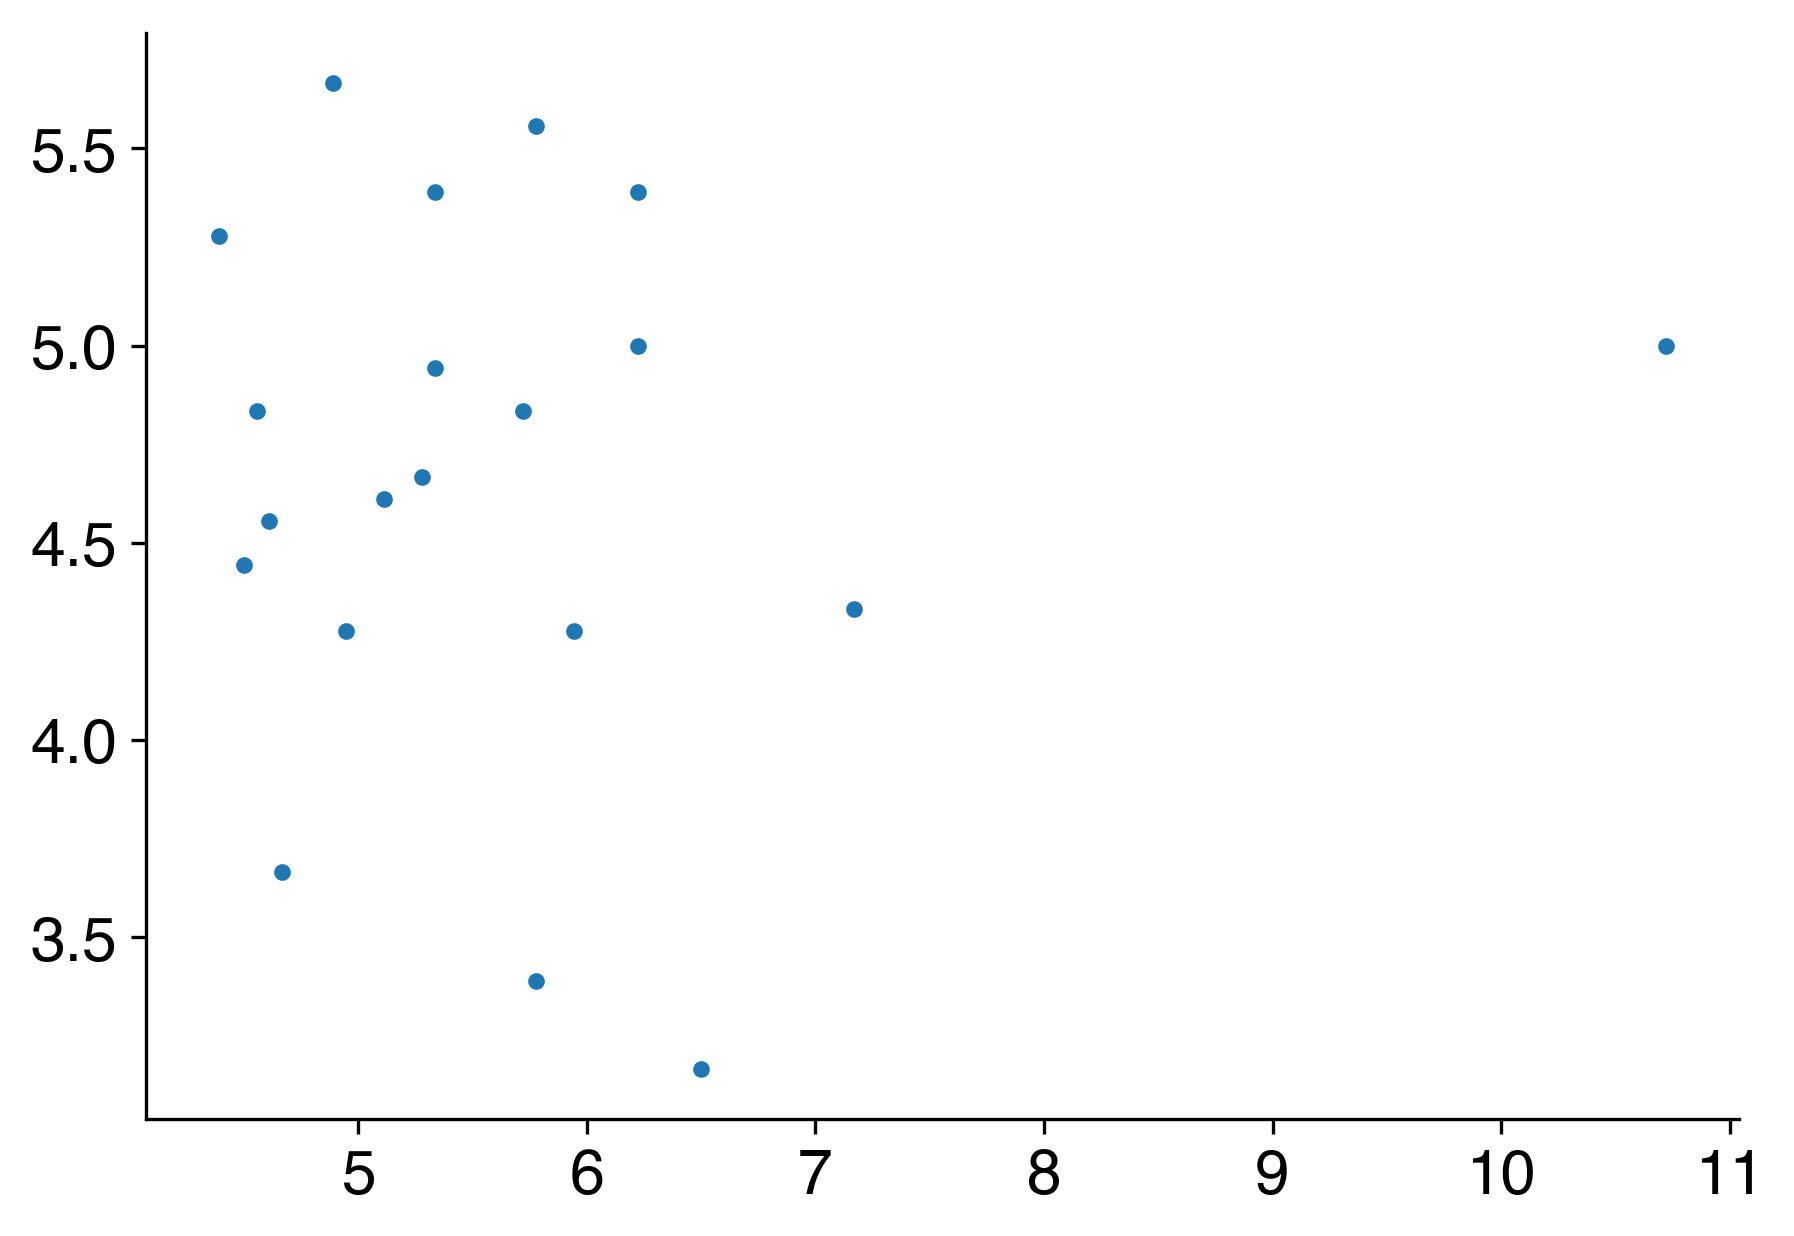

In [411]:
iUnit = 0
plt.scatter(split_frs['match'][0][0][iUnit, :], split_frs['match'][0][0][iUnit+1, :])

In [484]:
v1 = np.random.rand(1000)
v2 = np.random.rand(1000)

print('Original')
print(cos_sim(v1, v2), stats.pearsonr(v1, v2)[0])

print('\nNormalized')
print(cos_sim((v1 - np.mean(v1)), (v2 - np.mean(v2))), stats.pearsonr((v1 - np.mean(v1)), (v2 - np.mean(v2)))[0])
print(       cos_sim((v1 - np.mean(v1)) / np.std(v1), (v2 - np.mean(v2)) / np.std(v2)), 
      stats.pearsonr((v1 - np.mean(v1)) / np.std(v1), (v2 - np.mean(v2)) / np.std(v2))[0])

print('\nMultiplication')
print(cos_sim(10 * v1, 10 * v2), stats.pearsonr(10 * v1, 10 * v2)[0])
print(cos_sim(10 * v1, v2), stats.pearsonr(10 * v1, v2)[0])
print(cos_sim(-10 * v1, -10 * v2), stats.pearsonr(-10 * v1, -10 * v2)[0])
print(cos_sim(10 * v1, -10 * v2), stats.pearsonr(10 * v1, -10 * v2)[0])

print('\nAddition')
print(cos_sim(10 + v1, 10 + v2), stats.pearsonr(10 + v1, 10 + v2)[0])
print(cos_sim(10 + v1, v2), stats.pearsonr(10 + v1, v2)[0])
print(cos_sim(-10 + v1, -10 + v2), stats.pearsonr(-10 + v1, -10 + v2)[0])
print(cos_sim(10 + v1, -10 + v2), stats.pearsonr(10 + v1, -10 + v2)[0])

Original
0.7529359120343929 -0.0016479839655178464

Normalized
-0.0016479839655178464 -0.0016479839655178464
-0.0016479839655178486 -0.0016479839655178595

Multiplication
0.752935912034393 -0.0016479839655178488
0.752935912034393 -0.0016479839655178525
0.752935912034393 -0.0016479839655178488
-0.752935912034393 0.0016479839655178488

Addition
0.9992445533945947 -0.0016479839655178345
0.8642069562945998 -0.00164798396551784
0.9990755647792998 -0.0016479839655178345
-0.9991655852420843 -0.0016479839655178345


In [343]:
# Does the similarity between firing rate vectors across the delay interval
# differ when comparing Delay 1 and Delay 2 vs. trials 1-18 and 19-36?
# (For each neuron, calculate the Pearson correlation for these two comparisons,
#  where firing rate at each timepoint is a mean across trials.)
fr_corrs = []

# Trial 1-18 vs. trial 19-36 firing rate vectors (Delay 1 + Delay 2)
mpoint = int(trial_spikes_by_time.shape[1]/2)
trial_split_frs = [np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, :20], 
                                           trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100]), axis=1), axis=1),
                   np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, mpoint:, :20], 
                                           trial_spikes_by_time[sig_cells_delay, mpoint:, 80:100]), axis=1), axis=1)]
fr_corrs.append([stats.pearsonr(trial_split_frs[0][iUnit, :], trial_split_frs[1][iUnit, :])[0] for iUnit in range(trial_split_frs[0].shape[0])])

# Delay 1 vs. Delay 2 firing rate vectors (trials 1-36)
delay_frs = [np.mean(trial_spikes_by_time[sig_cells_delay, :, :20], axis=1), np.mean(trial_spikes_by_time[sig_cells_delay, :, 80:100], axis=1)]
fr_corrs.append([stats.pearsonr(delay_frs[0][iUnit, :], delay_frs[1][iUnit, :])[0] for iUnit in range(delay_frs[0].shape[0])])

fr_corrs = np.array(fr_corrs)

In [491]:
fr_corrs['match'].shape

(2, 19)

In [492]:
print(np.mean(fr_corrs['match'], axis=1), np.mean(fr_corrs['mismatch'], axis=1))
print(stats.ttest_rel(fr_corrs['match'][0, :], fr_corrs['match'][1, :]))
print(stats.ttest_rel(fr_corrs['match'][0, :], fr_corrs['mismatch'][0, :]))
print(stats.ttest_rel(fr_corrs['match'][0, :], fr_corrs['mismatch'][1, :]))
print(stats.ttest_rel(fr_corrs['match'][1, :], fr_corrs['mismatch'][0, :]))
print(stats.ttest_rel(fr_corrs['match'][1, :], fr_corrs['mismatch'][1, :]))

[0.38063759 0.45002451] [0.4199171  0.33509629]
Ttest_relResult(statistic=-0.9950219448079325, pvalue=0.3329144580269445)
Ttest_relResult(statistic=-0.6611321169761588, pvalue=0.5169013295266123)
Ttest_relResult(statistic=0.8629764950081334, pvalue=0.39950307443927746)
Ttest_relResult(statistic=0.8887011106861239, pvalue=0.3858862584298455)
Ttest_relResult(statistic=2.082191504261555, pvalue=0.051865907359078735)


In [344]:
stats.ttest_rel(fr_corrs[0, :], fr_corrs[1, :])

Ttest_relResult(statistic=0.6989644485808546, pvalue=0.49350765727442514)

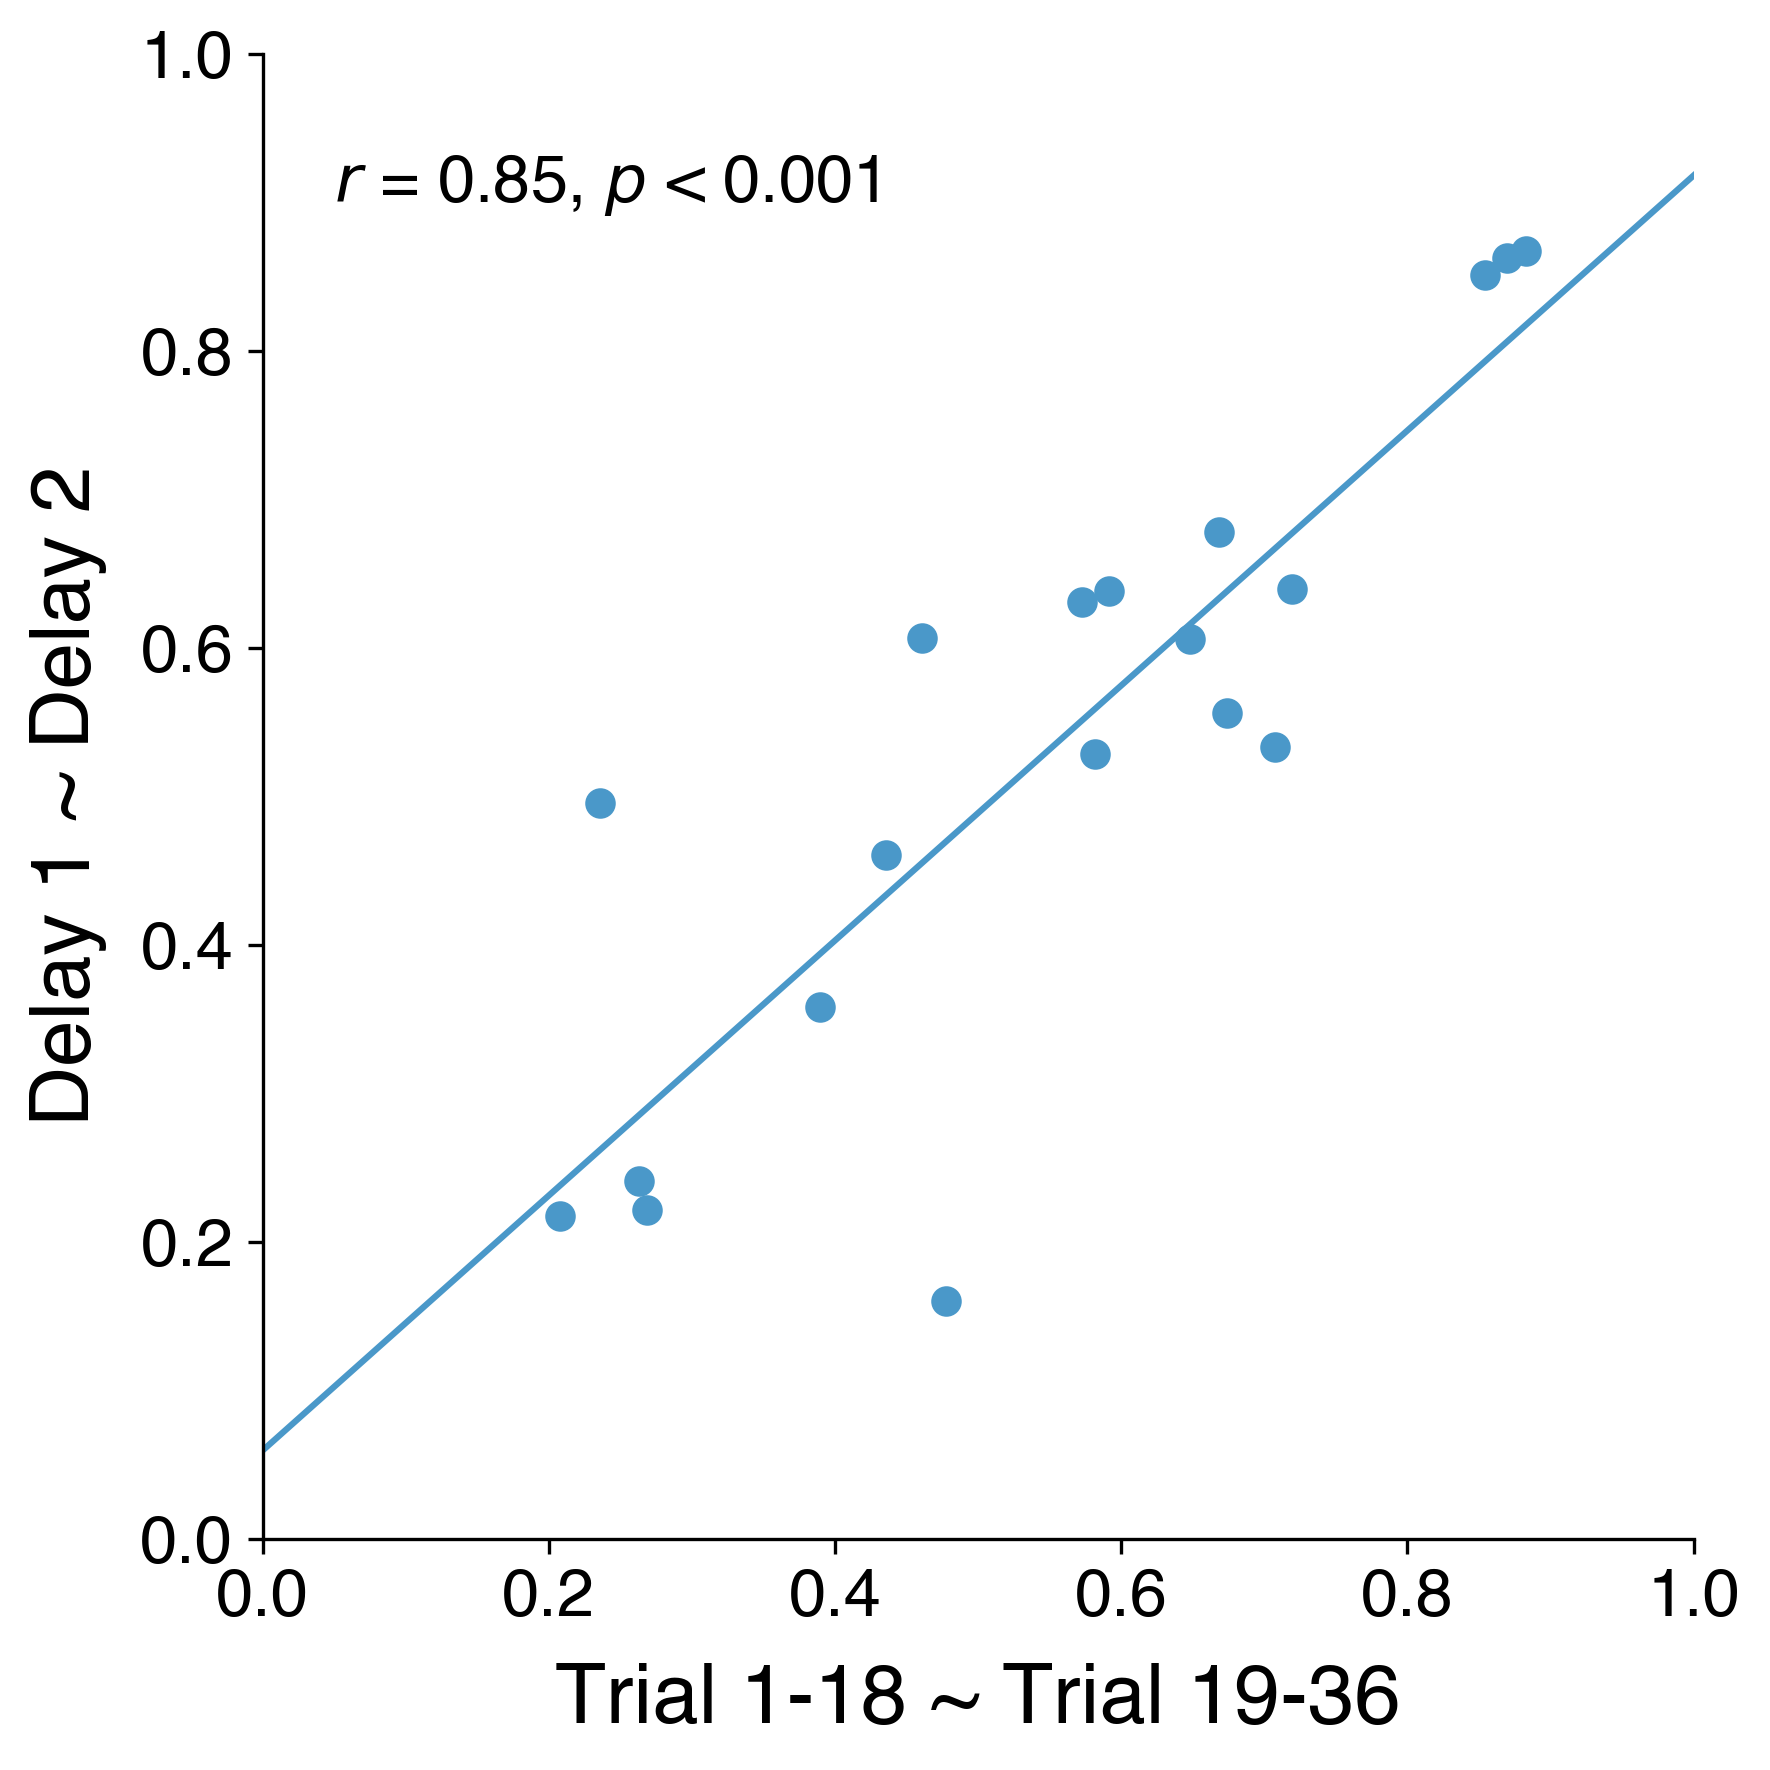

In [359]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 20

ax_min = 0
ax_max = 1
x_pred = np.linspace(ax_min, ax_max, 100)

i = 0
slope, icpt, r, p, _ = stats.linregress(fr_corrs[0, :], fr_corrs[1, :])
ax[i].plot(x_pred, icpt + (slope*x_pred), color=colors[0], linewidth=1.5)
ax[i].scatter(fr_corrs[0, :], fr_corrs[1, :], s=40, color=colors[0])
ax[i].set_xlim([ax_min, ax_max])
ax[i].set_xticks(np.arange(0, ax_max + 0.1, 0.2))
ax[i].set_xticklabels(np.round(np.arange(0, ax_max + 0.1, 0.2), 2), fontsize=tickfontsize)
ax[i].set_xlabel('Trial 1-18 ~ Trial 19-36', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylim([ax_min, ax_max])
ax[i].set_yticks(np.arange(0, ax_max + 0.1, 0.2))
ax[i].set_yticklabels(np.round(np.arange(0, ax_max + 0.1, 0.2), 2), fontsize=tickfontsize)
ax[i].set_ylabel('Delay 1 ~ Delay 2', fontsize=labelfontsize, labelpad=8)
if p < 0.001:
    ax[i].annotate('$r$ = {:.2f}, $p$ < 0.001'.format(r, p), (0.05, 0.9), xycoords='axes fraction', fontsize=tickfontsize, ha='left')
else:
    ax[i].annotate('$r$ = {:.2f}, $p$ = {:.3f}'.format(r, p), (0.05, 0.9), xycoords='axes fraction', fontsize=tickfontsize, ha='left')

fig.tight_layout()

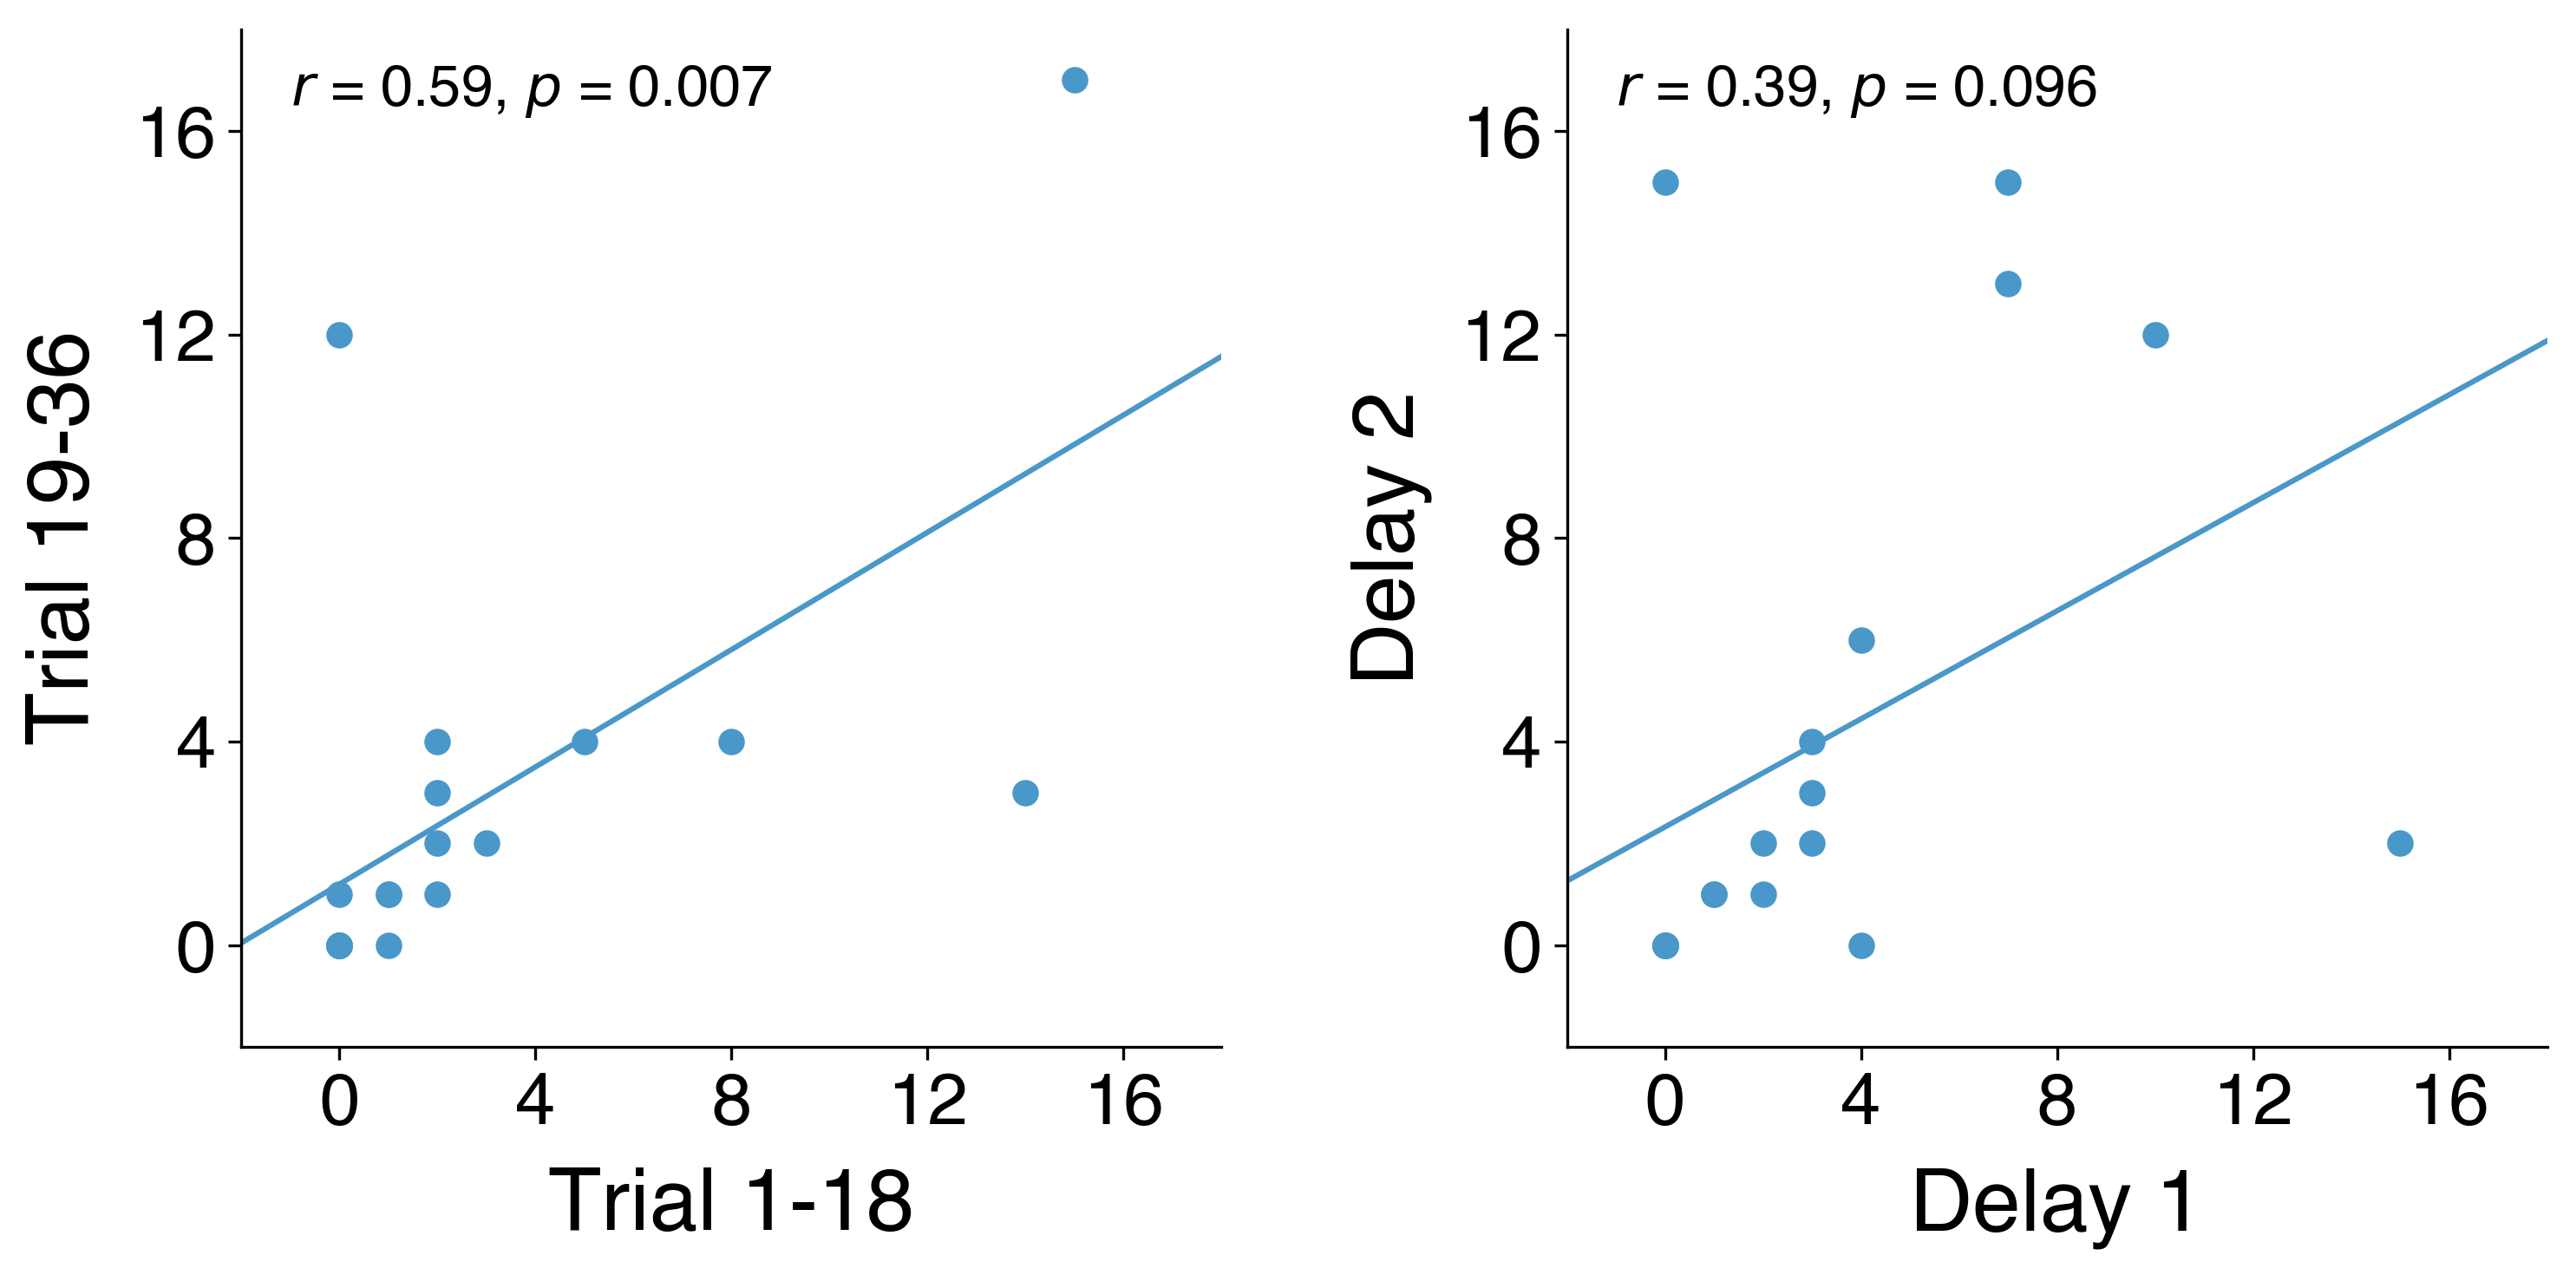

In [320]:
mpoint = int(trial_spikes_by_time.shape[1]/2)
# dat = [np.array([np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, :20], 
#                                                 trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100]), axis=1), axis=1), axis=1),
#               np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, mpoint:, :20], 
#                                                 trial_spikes_by_time[sig_cells_delay, mpoint:, 80:100]), axis=1), axis=1), axis=1)]),
#        np.array([np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, :20], axis=1), axis=1),
#                 np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, 80:100], axis=1), axis=1)])]

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 20
labelfontsize = 24
labs = [['Trial 1-18', 'Trial 19-36'], ['Delay 1', 'Delay 2']]
ax_min = -2
ax_max = 18
x_pred = np.linspace(ax_min, ax_max, 100)

for i in range(len(ax)):
    slope, icpt, r, p, _ = stats.linregress(dat[i][0, :], dat[i][1, :])
    ax[i].plot(x_pred, icpt + (slope*x_pred), color=colors[0], linewidth=1.5)
    ax[i].scatter(dat[i][0, :], dat[i][1, :], s=40, color=colors[0])
    ax[i].set_xlim([ax_min, ax_max])
    ax[i].set_xticks(np.arange(0, ax_max, 4, dtype=int))
    ax[i].set_xticklabels(np.arange(0, ax_max, 4, dtype=int), fontsize=tickfontsize)
    ax[i].set_xlabel(labs[i][0], fontsize=labelfontsize, labelpad=8)
    ax[i].set_ylim([ax_min, ax_max])
    ax[i].set_yticks(np.arange(0, ax_max, 4, dtype=int))
    ax[i].set_yticklabels(np.arange(0, ax_max, 4, dtype=int), fontsize=tickfontsize)
    ax[i].set_ylabel(labs[i][1], fontsize=labelfontsize, labelpad=8)
    ax[i].annotate('$r$ = {:.2f}, $p$ = {:.3f}'.format(r, p), (0.05, 0.925), xycoords='axes fraction', fontsize=tickfontsize-4, ha='left')

fig.tight_layout(w_pad=3.5)

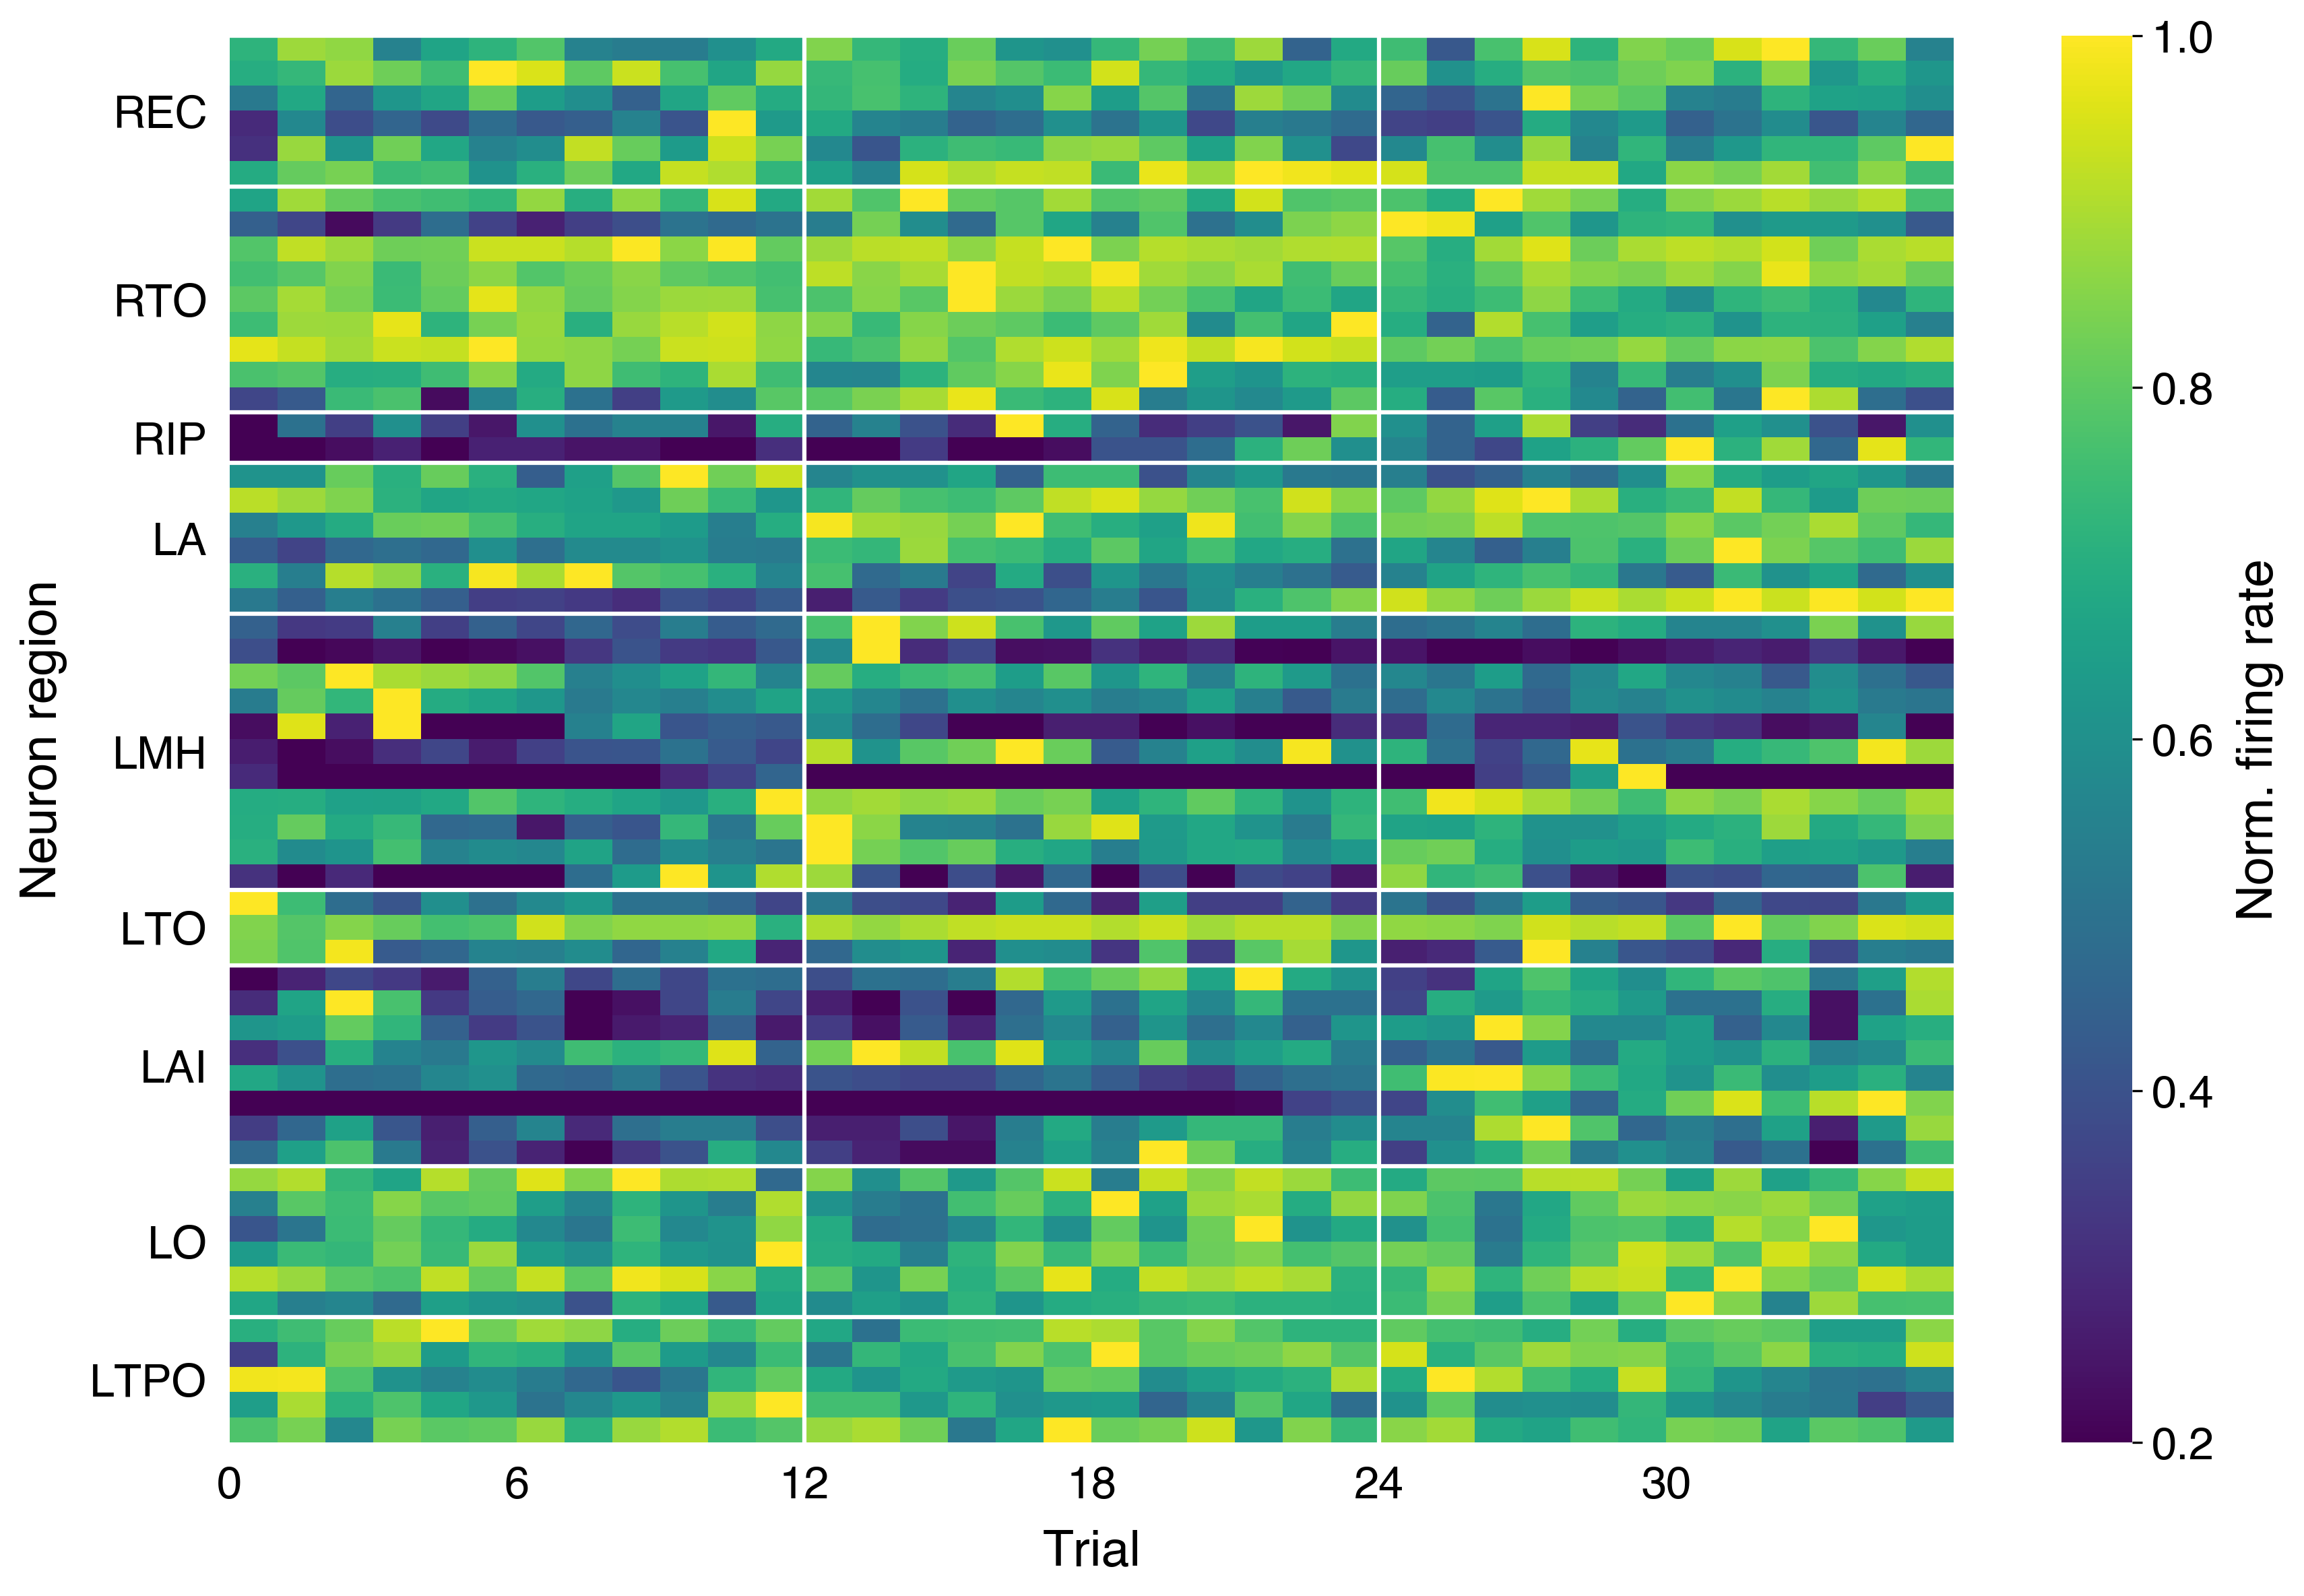

In [253]:
# Mean across times in each trial, for each neuron.
dat = np.sum(trial_spikes_by_time, axis=2) # neuron x trial
dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#dat = dat[np.argsort(dat.argmax(axis=-1)), :]

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
tickfontsize = 16
labelfontsize = 18

vmin = 0.2
vmax = 1
xticks = [10, 50, 90, 130]
yticks = (list(np.array(list(rois.values()))[:, 1][:-1] + np.diff(np.array(list(rois.values()))[:, 1])/2) 
          + [np.array(list(rois.values()))[-1, 1] + (np.array(list(rois.values()))[-1, 0]/2)])

ax = sns.heatmap(dat, ax=ax,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = [20, 80, 100, 160]
for breakTime in [12, 24]:
    ax.axvline(x=breakTime, color='w', linewidth=1.5, alpha=1)
for iRoi in range(len(rois)):
    ax.axhline(y=np.array(list(rois.values()))[:, 1][iRoi], color='w', linewidth=1.5, alpha=1)
ax.tick_params(axis='both', which='both', length=0, pad=8)
ax.set_xticks(np.arange(0, 36, 6))
ax.set_xticklabels(np.arange(0, 36, 6, dtype=int), fontsize=tickfontsize, rotation=0)
ax.set_xlabel('Trial', fontsize=labelfontsize, labelpad=8)
ax.set_yticks(yticks)
ax.set_yticklabels(list(rois.keys()), fontsize=tickfontsize)
ax.set_ylabel('Neuron region', fontsize=labelfontsize, labelpad=8)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_ticklabels(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()

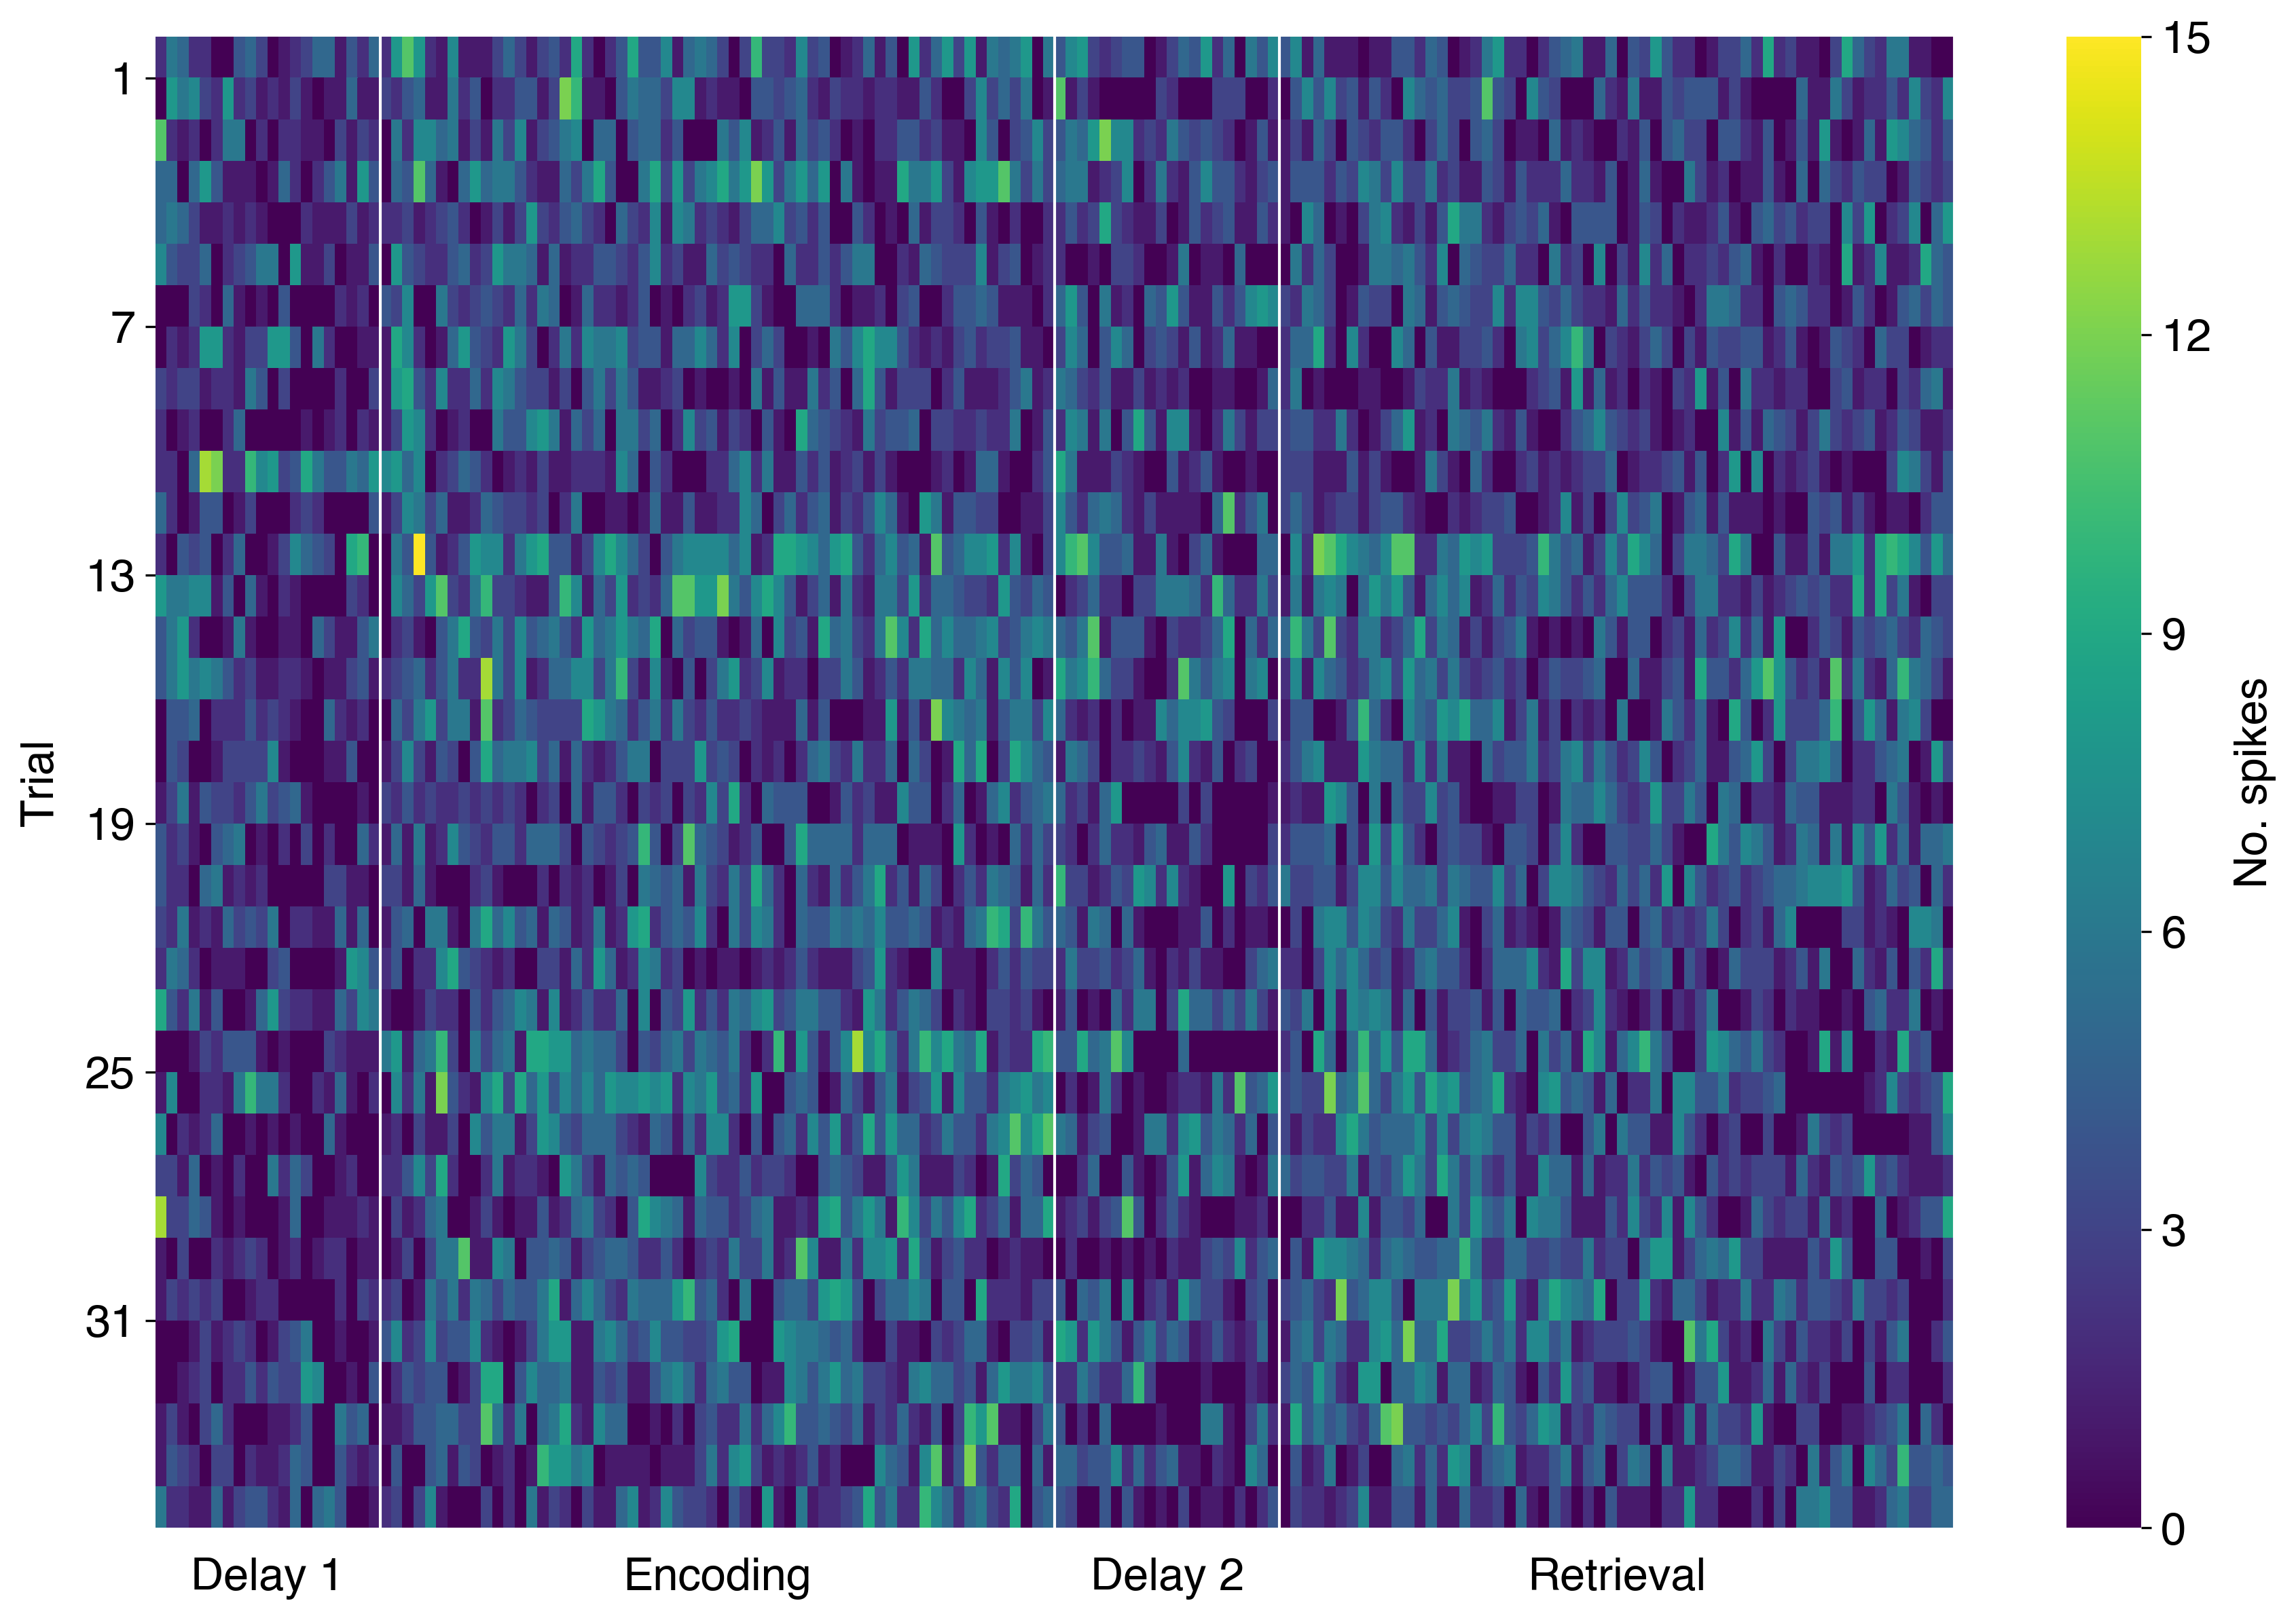

In [191]:
# Single neuron, trial x time.
iUnit = 32

dat = trial_spikes_by_time[iUnit, :, :] # trial x time
#dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#dat = dat[np.argsort(dat.argmax(axis=-1)), :]

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
labelfontsize = 16
tickfontsize = 16

vmin = 0
vmax = np.max(dat)

ax = sns.heatmap(dat, ax=ax,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = [20, 80, 100, 160]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='w', linewidth=1, alpha=1)
ax.set_xticks([])
ax.set_yticks(np.arange(1, 37, 6))
ax.set_yticklabels(np.arange(1, 37, 6, dtype=int), fontsize=tickfontsize, rotation=0)
ax.set_ylabel('Trial', fontsize=labelfontsize, labelpad=8)

ax.annotate('Delay 1', (10, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Encoding', (50, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Delay 2', (90, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Retrieval', (130, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.arange(vmin, vmax+1, int(vmax/6)+1, dtype=int))
cbar.set_ticklabels(np.arange(vmin, vmax+1, int(vmax/6)+1, dtype=int))
cbar.set_label('No. spikes', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()